 __Project - Employee attrition__

1. [Import](#Import)
    1. [Tools](#Tools)
    1. [Data](#Data)    
1. [EDA](#EDA)
    1. [Continuous feature EDA](#Continuous-feature-EDA)
    1. [Count feature EDA](#Count-feature-EDA)
    1. [Continuous feature EDA](#Continuous-feature-EDA)
    1. [Faceting](#Faceting)
    1. [Target variable evaluation](#Target-variable-evaluation)    
1. [Data preparation](#Data-preparation)
    1. [Missing data](#Missing-data)
    1. [Feature engineering](#Feature-engineering)
        1. [Handcrafted](#Handcrafted)
        1. [Polynomial features](#Polynomial-features)
        1. [Encoding](#Encoding)
    1. [Feature transformation](#Feature-transformation)
        1. [Skew correction](#Skew-correction)
        1. [Scaling](#Scaling)     
    1. [Outliers](#Outliers)
    1. [Additional exploratory data analysis](#Additional-exploratory-data-analysis)
1. [Feature importance](#Feature-importance)    
1. [Modeling](#Modeling)
    1. [Data preparation](#Data-preparation-1)
    1. [Bayesian hyper-parameter optimization](#Bayesian-hyper-parameter-optimization)
    1. [Model performance evaluation - standard models](#Model-performance-evaluation-standard-models)
    1. [Validation set evaluation - standard models](#Validation-set-evaluation-standard-models)
    1. [Model explanability](#Model-explanability)
1. [Stacking](#Stacking)
    1. [Primary models](#Primary-models)
    1. [Meta model](#Meta-model)                
    1. [Model performance evaluation - stacked models](#Model-performance-evaluation-stacked-models)
    1. [Validation set evaluation - stacked models](#Validation-set-evaluation-stacked-models)


# Import

<a id = 'Import'></a>

## Tools

<a id = 'Tools'></a>

In [1]:
# standard libary and settings
import copy
import os
import sys
import importlib
import itertools
from functools import reduce
import time

rundate = time.strftime("%Y%m%d")

import warnings

warnings.simplefilter("ignore")

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)

import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
# pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    IsolationForest,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    Lasso,
    Ridge,
    ElasticNet,
    LinearRegression,
    LogisticRegression,
    SGDRegressor,
)
from sklearn.model_selection import (
    KFold,
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    RandomizedSearchCV,
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    PolynomialFeatures,
    OrdinalEncoder,
    LabelEncoder,
    OneHotEncoder,
    KBinsDiscretizer,
    QuantileTransformer,
    PowerTransformer,
    MinMaxScaler,
)
from sklearn.svm import SVC, SVR
from category_encoders import (
    WOEEncoder,
    TargetEncoder,
    CatBoostEncoder,
    BinaryEncoder,
    CountEncoder,
)

from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from hyperopt import hp

import eif
import shap

shap.initjs()

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import squarify

%matplotlib inline

try:
    #     import mlmachine as mlm
    #     from prettierplot.plotter import PrettierPlot
    #     import prettierplot.style as style
    import asdfasd
except ModuleNotFoundError:
    sys.path.append(
        "../../../mlmachine"
    ) if "../../../../mlmachine" not in sys.path else None
    sys.path.append(
        "../../../prettierplot"
    ) if "../../../../prettierplot" not in sys.path else None

    import mlmachine as mlm
    import mlmachine.data as data
    from mlmachine.features.preprocessing import (
        DataFrameSelector,
        PandasTransformer,
        KFoldSelectEncoder,
        ContextImputer,
        PandasFeatureUnion,
        DualTransformer,
    )
    from prettierplot.plotter import PrettierPlot
    import prettierplot.style as style
else:
    print(
        "This notebook relies on the libraries mlmachine and prettierplot. Please run:"
    )
    print("\tpip install mlmachine")
    print("\tpip install prettierplot")

## Data

<a id = 'Data'></a>

In [2]:
# load data and print dimensions
dataset = data.attrition()
print("Training data dimensions: {}".format(dataset.shape))

Training data dimensions: (1470, 35)


In [3]:
# display info and first 5 rows
dataset.info()
display(dataset[:5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel  \
0                        2  Female          94               3         2   
1                        3    Male          61               2         2   
2                        4    Male          92               2         1   
3                        4  Female          56               3         1   
4                        1    Male          40               3         1   

                 JobRole  JobSatisfaction MaritalStatus  MonthlyIncome  \
0        Sales Executive                4        Single           5993   
1     Research Scientist                2       Married           5130   
2  Laboratory Technician                3        Single           2090   
3     Research Scientist                3       Married           2909   
4  Laboratory Technician                2       Married           3468   

   MonthlyRate  NumCompaniesWorked Over18 OverTime  PercentSalaryHike  \
0        19479                   8      Y      Yes                 11   
1        24907                   1      Y       No                 23   
2         2396                   6      Y      Yes                 15   
3        23159                   1      Y      Yes                 11   
4        16632                   9      Y       No                 12   

   PerformanceRating  RelationshipSatisfaction  StandardHours  \
0                  3                         1             80   
1                  4                         4             80   
2                  3                         2             80   
3                  3                         3             80   
4                  3                         4             80   

   StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  \
0                 0                  8                      0   
1                 1                 10                      3   
2                 0                  7                      3   
3                 0                  8                      3   
4                 1                  6                      3   

   WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
0                1               6                   4   
1                3              10                   7   
2                3               0                   0   
3                3               8                   7   
4                3               2                   2   

   YearsSinceLastPromotion  YearsWithCurrManager  
0                        0                     5  
1                        1                     7  
2                        0                     0  
3                        3                     0  
4                        2                     2

In [4]:
# review counts of different column types
dataset.dtypes.value_counts()

int64     26
object     9
dtype: int64

In [5]:
# split dataset into train and validation datasets
df_train, df_valid = mlm.train_test_df_compile(data=dataset, target_col='Attrition')

In [6]:
continuous = [
    "Age",
    "DailyRate",
    "DistanceFromHome",
    "HourlyRate",
    "MonthlyIncome",
    "MonthlyRate",
    "PercentSalaryHike",
    "TotalWorkingYears",
    "YearsAtCompany",
    "YearsInCurrentRole",
    "YearsSinceLastPromotion",
    "YearsWithCurrManager",
]

count = [
    "NumCompaniesWorked",
    "TrainingTimesLastYear",
]

nominal = [
    "MaritalStatus",
    "EducationField",
    "Department",
    "Gender",
    "JobRole",
    "OverTime",
]

remove_features = [
    "EmployeeNumber",
    "EmployeeCount",
    "StandardHours",
    "Over18",
]

ordinal = [
    "Education",
    "EnvironmentSatisfaction",
    "JobInvolvement",
    "JobLevel",
    "JobSatisfaction",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StockOptionLevel",
    "WorkLifeBalance",
    "BusinessTravel",
]

ordinal_encodings = {
    "Education": [1, 2, 3, 4, 5],
    "EnvironmentSatisfaction": [1, 2, 3, 4],
    "JobInvolvement": [1, 2, 3, 4],
    "JobLevel": [1, 2, 3, 4, 5],
    "JobSatisfaction": [1, 2, 3, 4],
    "PerformanceRating": [3, 4],
    "RelationshipSatisfaction": [1, 2, 3, 4],
    "StockOptionLevel": [0, 1, 2, 3],
    "WorkLifeBalance": [1, 2, 3, 4],
    "BusinessTravel": ['Non-Travel','Travel_Rarely','Travel_Frequently'],
}

In [7]:
# Load training data into mlmachine
train = mlm.Machine(
    data=df_train,
    target="Attrition",
    remove_features=remove_features,
    identify_as_continuous=continuous,
    identify_as_count=count,    
    identify_as_nominal=nominal,
    identify_as_ordinal=ordinal,
    ordinal_encodings=ordinal_encodings,
    target_type="category",
)

>>> category label encoding

	No --> 0
	Yes --> 1



In [8]:
# Load training data into mlmachine
valid = mlm.Machine(
    data=df_valid,
    target="Attrition",
    remove_features=remove_features,
    identify_as_continuous=continuous,
    identify_as_count=count,    
    identify_as_nominal=nominal,
    identify_as_ordinal=ordinal,
    ordinal_encodings=ordinal_encodings,
)

# EDA

<a id = 'EDA'></a>

## Category feature EDA

<a id = 'Category-feature-EDA'></a>

Feature summary Feature vs. target summary Target proportion 
 
 
 Department 
 Count 
 Proportion 
 
 
 
 
 Research & Development 
 775 
 65.901361 
 
 
 Sales 
 351 
 29.846939 
 
 
 Human Resources 
 50 
 4.251701 
 
 
 
 
 
 Department 
 Stayed 
 Left 
 
 
 
 
 Human Resources 
 38 
 12 
 
 
 Research & Development 
 669 
 106 
 
 
 Sales 
 279 
 72 
 
 
 
 
 
 Class 
 Human Resources 
 Research & Development 
 Sales 
 
 
 
 
 Stayed 
 76.0 
 86.322581 
 79.487179 
 
 
 Left 
 24.0 
 13.677419 
 20.512821

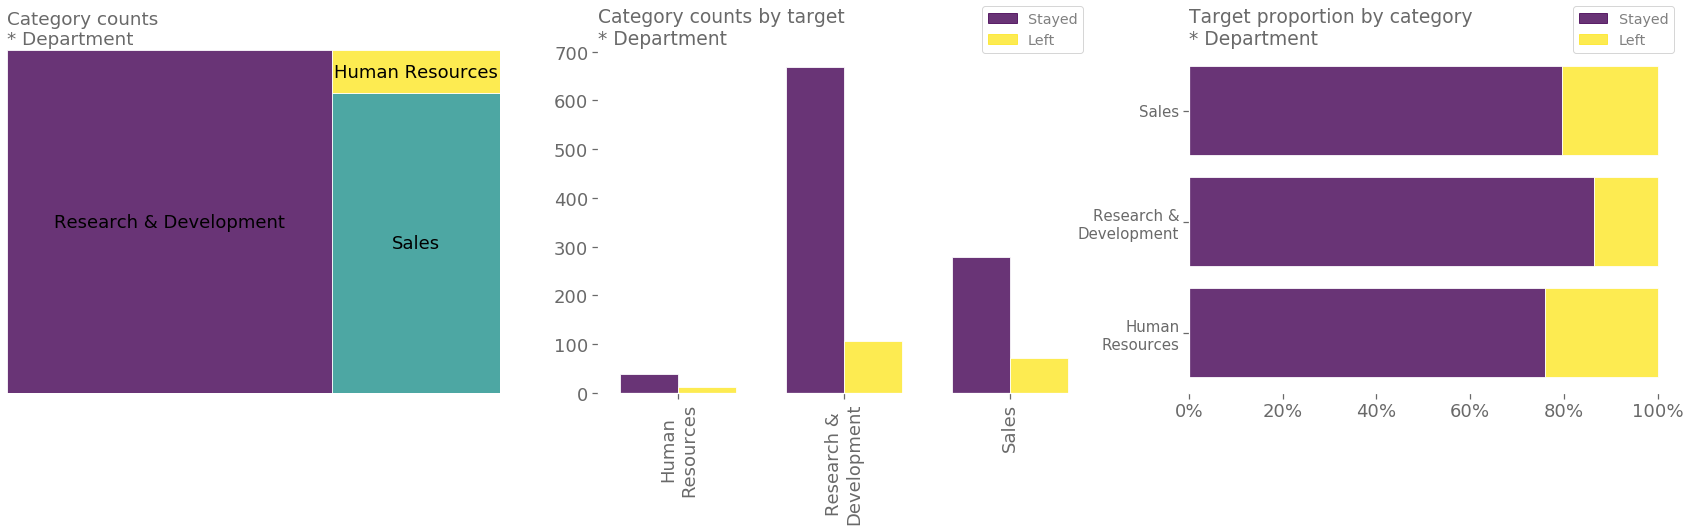

Feature summary Feature vs. target summary Target proportion 
 
 
 EducationField 
 Count 
 Proportion 
 
 
 
 
 Life Sciences 
 480 
 40.816327 
 
 
 Medical 
 372 
 31.632653 
 
 
 Marketing 
 129 
 10.969388 
 
 
 Technical Degree 
 105 
 8.928571 
 
 
 Other 
 68 
 5.782313 
 
 
 Human Resources 
 22 
 1.870748 
 
 
 
 
 
 EducationField 
 Stayed 
 Left 
 
 
 
 
 Human Resources 
 15 
 7 
 
 
 Life Sciences 
 414 
 66 
 
 
 Marketing 
 102 
 27 
 
 
 Medical 
 320 
 52 
 
 
 Other 
 58 
 10 
 
 
 Technical Degree 
 77 
 28 
 
 
 
 
 
 Class 
 Human Resources 
 Life Sciences 
 Marketing 
 Medical 
 Other 
 Technical Degree 
 
 
 
 
 Stayed 
 68.181818 
 86.25 
 79.069767 
 86.021505 
 85.294118 
 73.333333 
 
 
 Left 
 31.818182 
 13.75 
 20.930233 
 13.978495 
 14.705882 
 26.666667

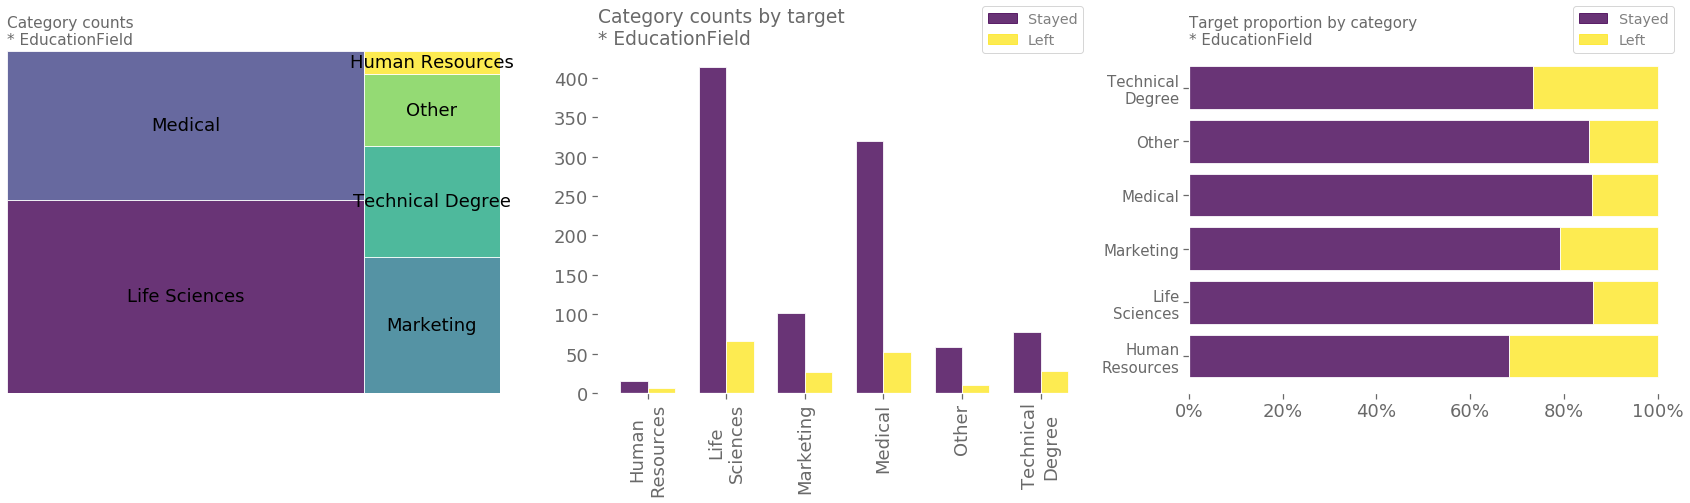

Feature summary Feature vs. target summary Target proportion Statistical test 
 
 
 Gender 
 Count 
 Proportion 
 
 
 
 
 Male 
 709 
 60.289116 
 
 
 Female 
 467 
 39.710884 
 
 
 
 
 
 Gender 
 Stayed 
 Left 
 
 
 
 
 Female 
 405 
 62 
 
 
 Male 
 581 
 128 
 
 
 
 
 
 Class 
 Female 
 Male 
 
 
 
 
 Stayed 
 86.723769 
 81.946403 
 
 
 Left 
 13.276231 
 18.053597 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 -2.178 
 0.0294

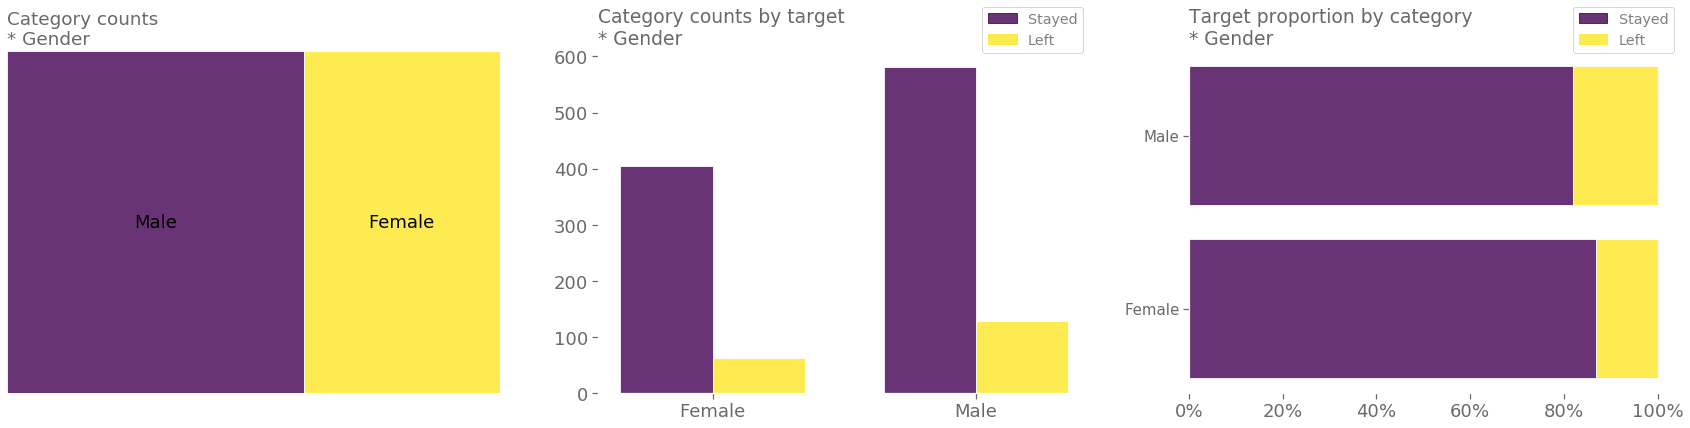

Feature summary Feature vs. target summary Target proportion 
 
 
 JobRole 
 Count 
 Proportion 
 
 
 
 
 Sales Executive 
 262 
 22.278912 
 
 
 Research Scientist 
 232 
 19.727891 
 
 
 Laboratory Technician 
 208 
 17.687075 
 
 
 Manufacturing Director 
 116 
 9.863946 
 
 
 Healthcare Representative 
 112 
 9.523810 
 
 
 Manager 
 84 
 7.142857 
 
 
 Research Director 
 62 
 5.272109 
 
 
 Sales Representative 
 59 
 5.017007 
 
 
 Human Resources 
 41 
 3.486395 
 
 
 
 
 
 JobRole 
 Stayed 
 Left 
 
 
 
 
 Healthcare Representative 
 103 
 9 
 
 
 Human Resources 
 29 
 12 
 
 
 Laboratory Technician 
 158 
 50 
 
 
 Manager 
 81 
 3 
 
 
 Manufacturing Director 
 107 
 9 
 
 
 Research Director 
 61 
 1 
 
 
 Research Scientist 
 196 
 36 
 
 
 Sales Executive 
 214 
 48 
 
 
 Sales Representative 
 37 
 22 
 
 
 
 
 
 Class 
 Healthcare Representative 
 Human Resources 
 Laboratory Technician 
 Manager 
 Manufacturing Director 
 Research Director 
 Research Scientist 
 Sales Executive 
 Sales Representative 
 
 
 
 
 Stayed 
 91.964286 
 70.731707 
 75.961538 
 96.428571 
 92.241379 
 98.387097 
 84.482759 
 81.679389 
 62.711864 
 
 
 Left 
 8.035714 
 29.268293 
 24.038462 
 3.571429 
 7.758621 
 1.612903 
 15.517241 
 18.320611 
 37.288136

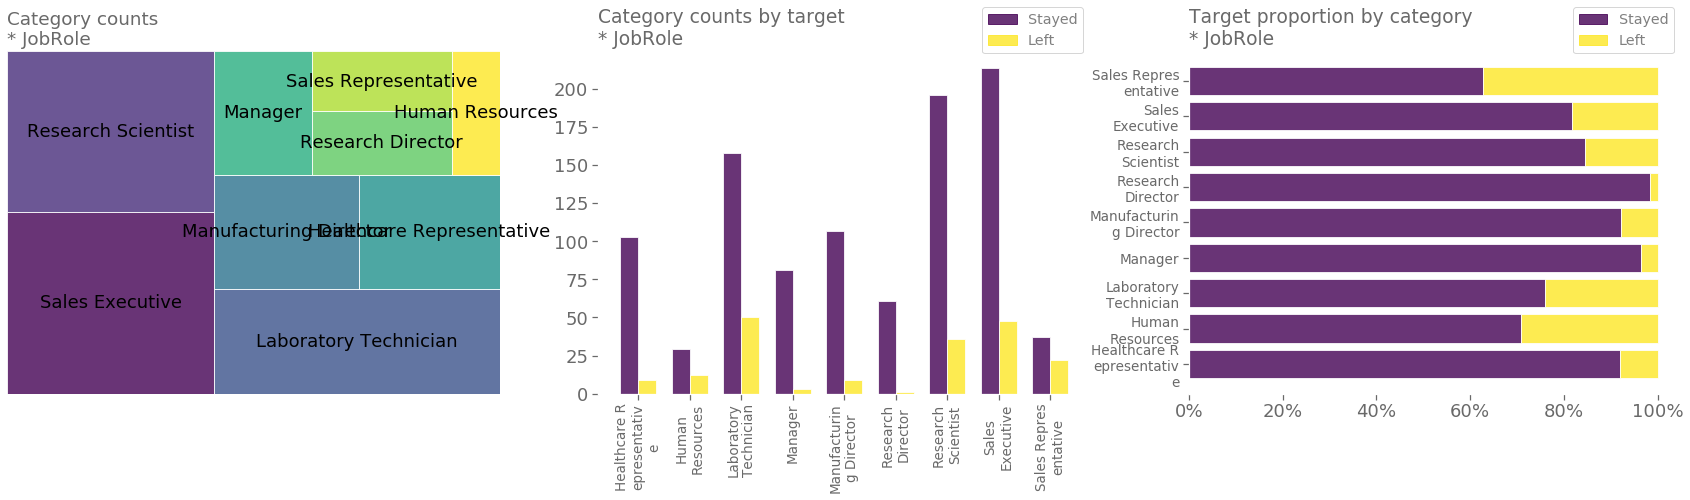

Feature summary Feature vs. target summary Target proportion 
 
 
 MaritalStatus 
 Count 
 Proportion 
 
 
 
 
 Married 
 548 
 46.598639 
 
 
 Single 
 363 
 30.867347 
 
 
 Divorced 
 265 
 22.534014 
 
 
 
 
 
 MaritalStatus 
 Stayed 
 Left 
 
 
 
 
 Divorced 
 240 
 25 
 
 
 Married 
 478 
 70 
 
 
 Single 
 268 
 95 
 
 
 
 
 
 Class 
 Divorced 
 Married 
 Single 
 
 
 
 
 Stayed 
 90.566038 
 87.226277 
 73.829201 
 
 
 Left 
 9.433962 
 12.773723 
 26.170799

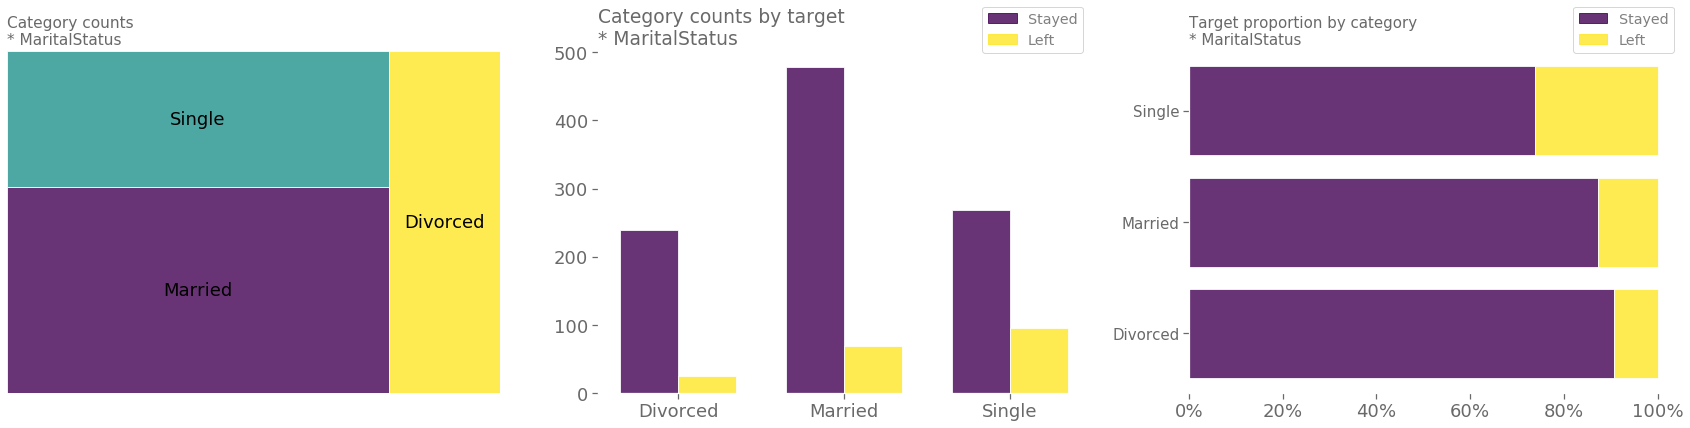

Feature summary Feature vs. target summary Target proportion Statistical test 
 
 
 OverTime 
 Count 
 Proportion 
 
 
 
 
 No 
 863 
 73.384354 
 
 
 Yes 
 313 
 26.615646 
 
 
 
 
 
 OverTime 
 Stayed 
 Left 
 
 
 
 
 No 
 765 
 98 
 
 
 Yes 
 221 
 92 
 
 
 
 
 
 Class 
 No 
 Yes 
 
 
 
 
 Stayed 
 88.644264 
 70.607029 
 
 
 Left 
 11.355736 
 29.392971 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 -7.4274 
 0.0

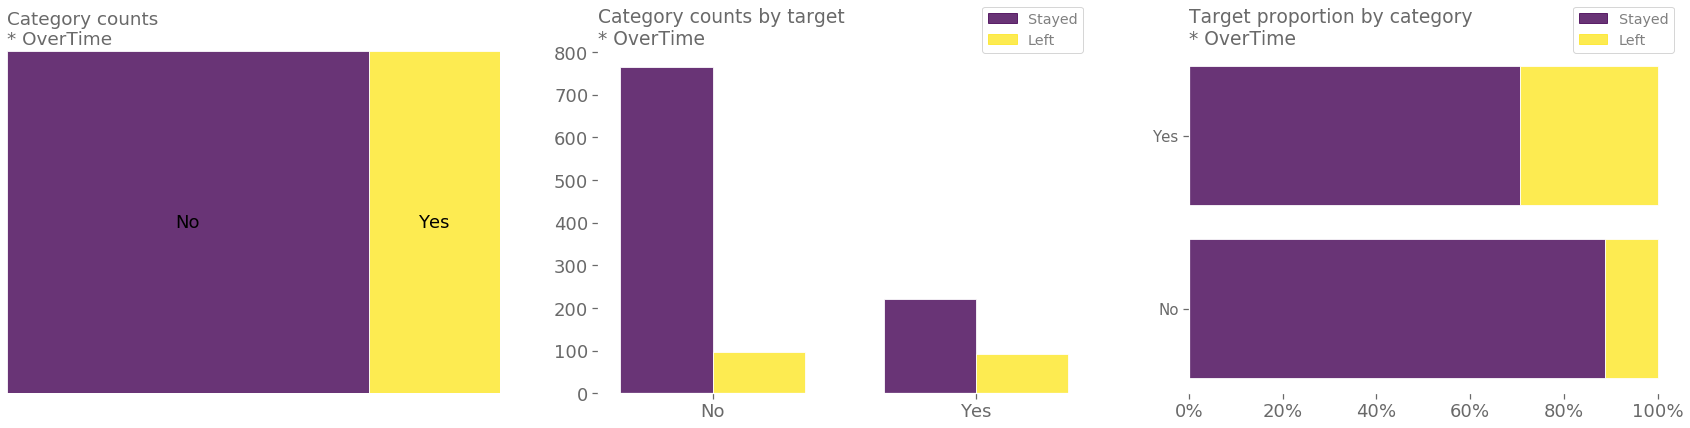

Feature summary Feature vs. target summary Target proportion 
 
 
 BusinessTravel 
 Count 
 Proportion 
 
 
 
 
 Travel_Rarely 
 834 
 70.918367 
 
 
 Travel_Frequently 
 219 
 18.622449 
 
 
 Non-Travel 
 123 
 10.459184 
 
 
 
 
 
 BusinessTravel 
 Stayed 
 Left 
 
 
 
 
 Non-Travel 
 113 
 10 
 
 
 Travel_Rarely 
 709 
 125 
 
 
 Travel_Frequently 
 164 
 55 
 
 
 
 
 
 Class 
 Non-Travel 
 Travel_Rarely 
 Travel_Frequently 
 
 
 
 
 Stayed 
 91.869919 
 85.01199 
 74.885845 
 
 
 Left 
 8.130081 
 14.98801 
 25.114155

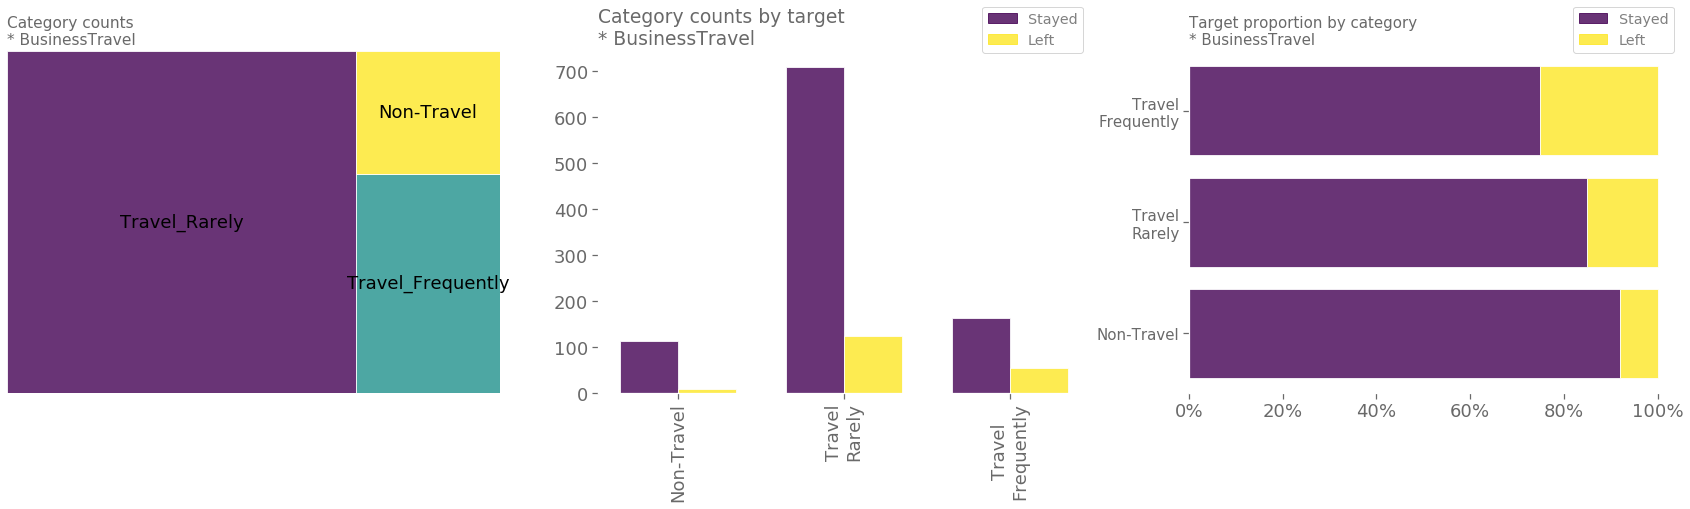

Feature summary Feature vs. target summary Target proportion 
 
 
 Education 
 Count 
 Proportion 
 
 
 
 
 3 
 469 
 39.880952 
 
 
 4 
 311 
 26.445578 
 
 
 2 
 230 
 19.557823 
 
 
 1 
 133 
 11.309524 
 
 
 5 
 33 
 2.806122 
 
 
 
 
 
 Education 
 Stayed 
 Left 
 
 
 
 
 1 
 108 
 25 
 
 
 2 
 198 
 32 
 
 
 3 
 392 
 77 
 
 
 4 
 259 
 52 
 
 
 5 
 29 
 4 
 
 
 
 
 
 Class 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 Stayed 
 81.203008 
 86.086957 
 83.58209 
 83.279743 
 87.878788 
 
 
 Left 
 18.796992 
 13.913043 
 16.41791 
 16.720257 
 12.121212

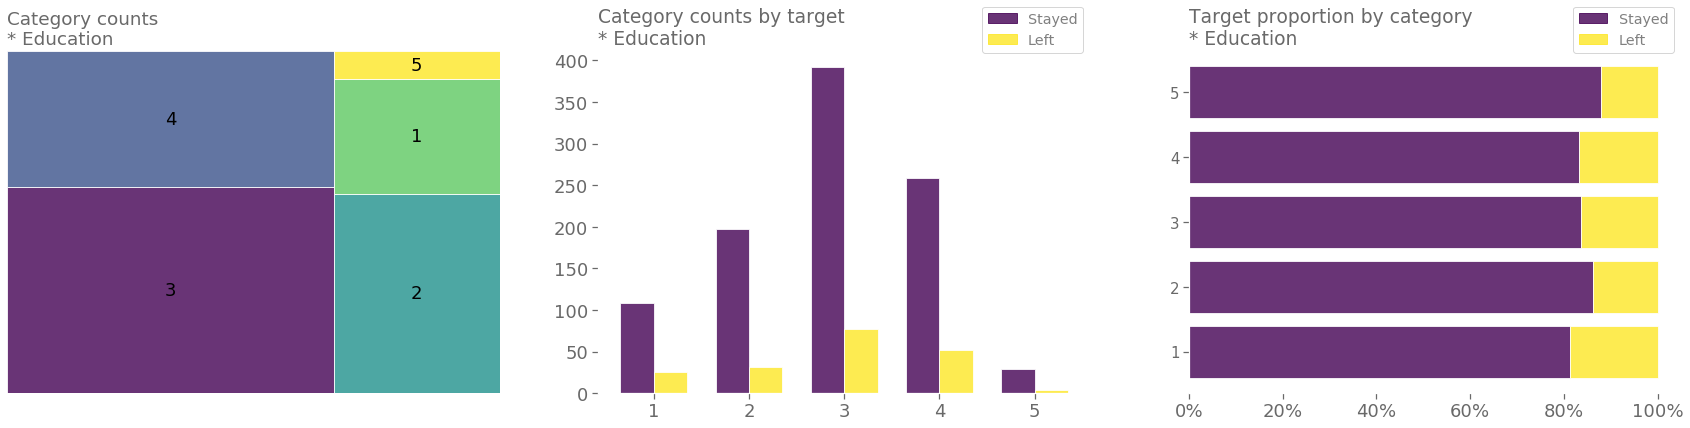

Feature summary Feature vs. target summary Target proportion 
 
 
 EnvironmentSatisfaction 
 Count 
 Proportion 
 
 
 
 
 4 
 362 
 30.782313 
 
 
 3 
 352 
 29.931973 
 
 
 1 
 240 
 20.408163 
 
 
 2 
 222 
 18.877551 
 
 
 
 
 
 EnvironmentSatisfaction 
 Stayed 
 Left 
 
 
 
 
 1 
 177 
 63 
 
 
 2 
 191 
 31 
 
 
 3 
 303 
 49 
 
 
 4 
 315 
 47 
 
 
 
 
 
 Class 
 1 
 2 
 3 
 4 
 
 
 
 
 Stayed 
 73.75 
 86.036036 
 86.079545 
 87.016575 
 
 
 Left 
 26.25 
 13.963964 
 13.920455 
 12.983425

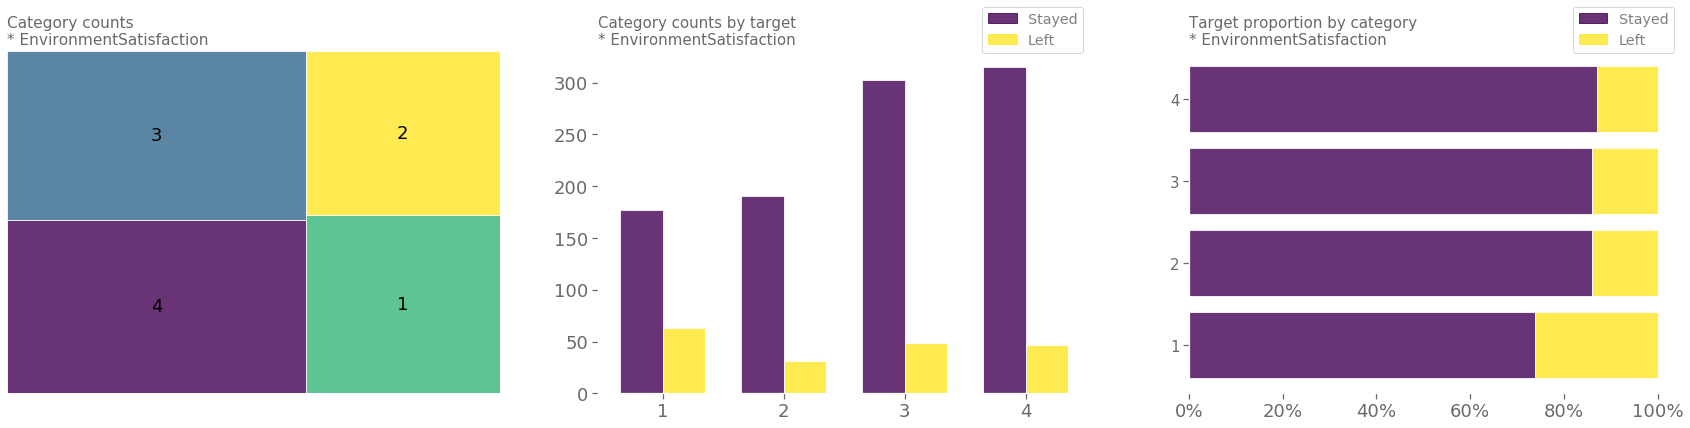

Feature summary Feature vs. target summary Target proportion 
 
 
 JobInvolvement 
 Count 
 Proportion 
 
 
 
 
 3 
 692 
 58.843537 
 
 
 2 
 294 
 25.000000 
 
 
 4 
 121 
 10.289116 
 
 
 1 
 69 
 5.867347 
 
 
 
 
 
 JobInvolvement 
 Stayed 
 Left 
 
 
 
 
 1 
 44 
 25 
 
 
 2 
 240 
 54 
 
 
 3 
 592 
 100 
 
 
 4 
 110 
 11 
 
 
 
 
 
 Class 
 1 
 2 
 3 
 4 
 
 
 
 
 Stayed 
 63.768116 
 81.632653 
 85.549133 
 90.909091 
 
 
 Left 
 36.231884 
 18.367347 
 14.450867 
 9.090909

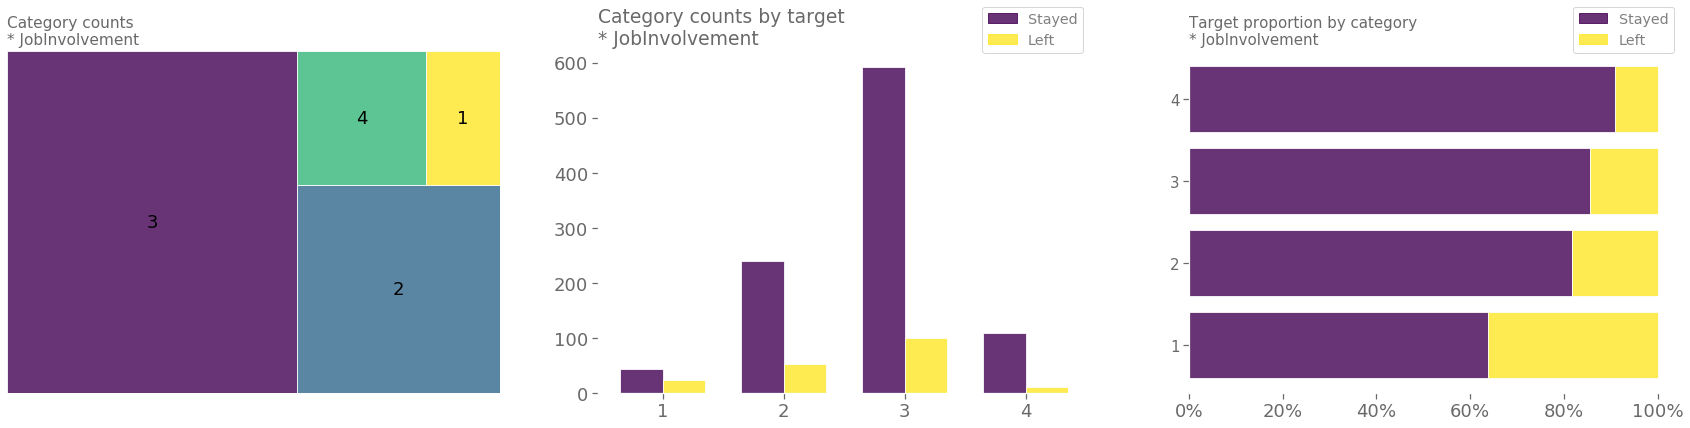

Feature summary Feature vs. target summary Target proportion 
 
 
 JobLevel 
 Count 
 Proportion 
 
 
 
 
 2 
 430 
 36.564626 
 
 
 1 
 424 
 36.054422 
 
 
 3 
 180 
 15.306122 
 
 
 4 
 88 
 7.482993 
 
 
 5 
 54 
 4.591837 
 
 
 
 
 
 JobLevel 
 Stayed 
 Left 
 
 
 
 
 1 
 315 
 109 
 
 
 2 
 385 
 45 
 
 
 3 
 151 
 29 
 
 
 4 
 84 
 4 
 
 
 5 
 51 
 3 
 
 
 
 
 
 Class 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 Stayed 
 74.292453 
 89.534884 
 83.888889 
 95.454545 
 94.444444 
 
 
 Left 
 25.707547 
 10.465116 
 16.111111 
 4.545455 
 5.555556

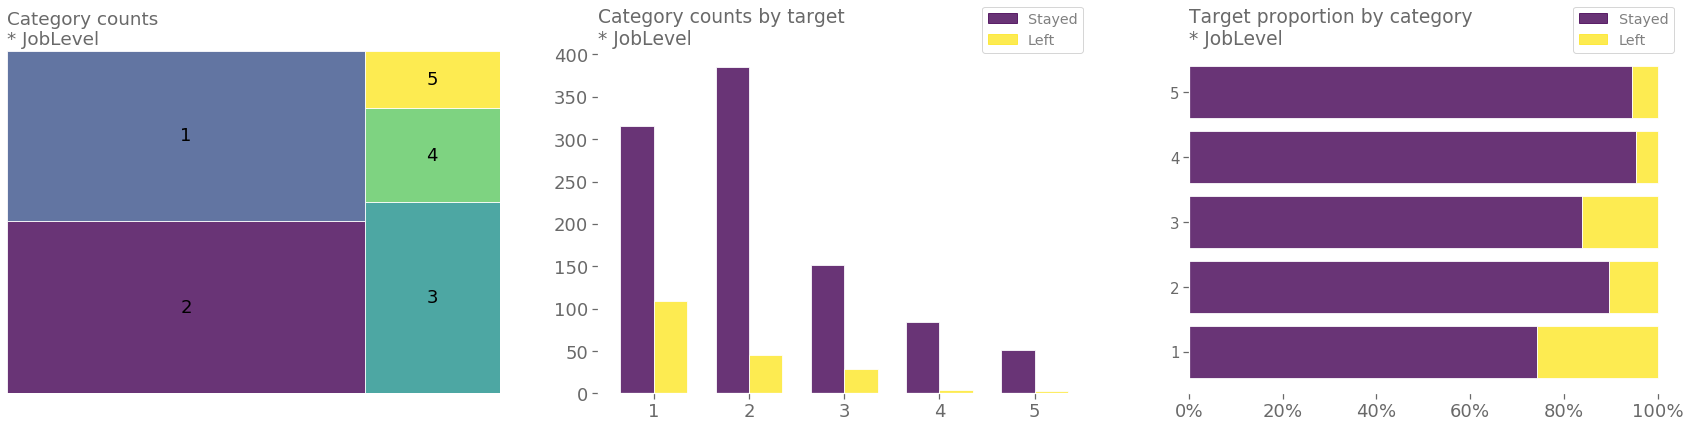

Feature summary Feature vs. target summary Target proportion 
 
 
 JobSatisfaction 
 Count 
 Proportion 
 
 
 
 
 4 
 374 
 31.802721 
 
 
 3 
 360 
 30.612245 
 
 
 1 
 221 
 18.792517 
 
 
 2 
 221 
 18.792517 
 
 
 
 
 
 JobSatisfaction 
 Stayed 
 Left 
 
 
 
 
 1 
 168 
 53 
 
 
 2 
 187 
 34 
 
 
 3 
 303 
 57 
 
 
 4 
 328 
 46 
 
 
 
 
 
 Class 
 1 
 2 
 3 
 4 
 
 
 
 
 Stayed 
 76.0181 
 84.615385 
 84.166667 
 87.700535 
 
 
 Left 
 23.9819 
 15.384615 
 15.833333 
 12.299465

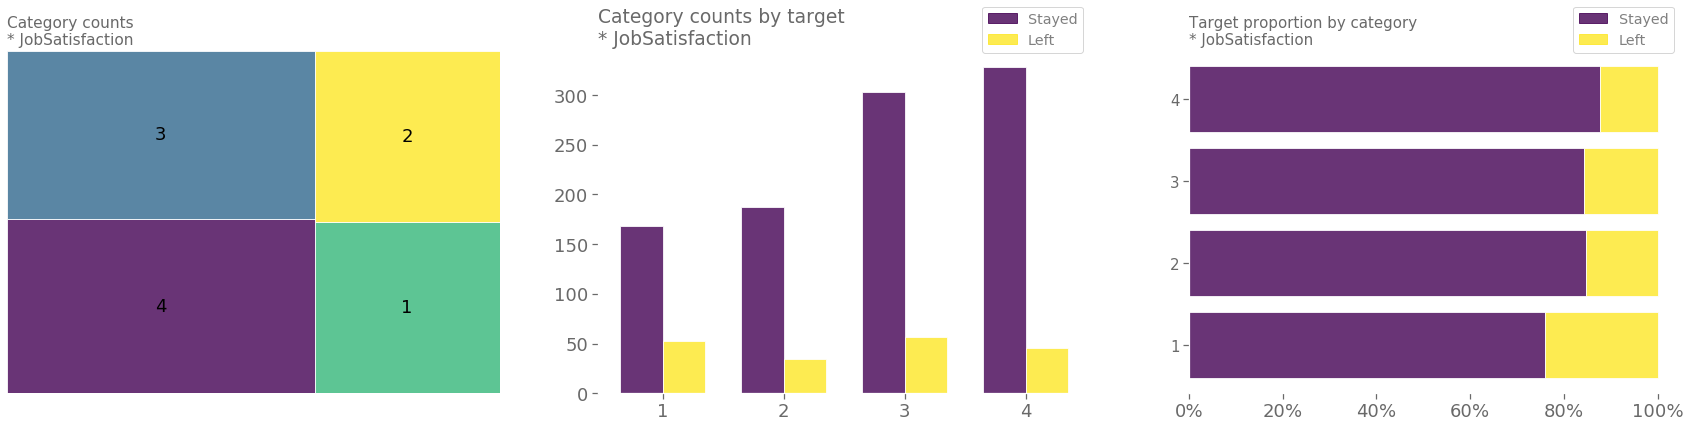

Feature summary Feature vs. target summary Target proportion Statistical test 
 
 
 PerformanceRating 
 Count 
 Proportion 
 
 
 
 
 3 
 994 
 84.52381 
 
 
 4 
 182 
 15.47619 
 
 
 
 
 
 PerformanceRating 
 Stayed 
 Left 
 
 
 
 
 3 
 835 
 159 
 
 
 4 
 151 
 31 
 
 
 
 
 
 Class 
 3 
 4 
 
 
 
 
 Stayed 
 84.004024 
 82.967033 
 
 
 Left 
 15.995976 
 17.032967 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 -0.3495 
 0.7267

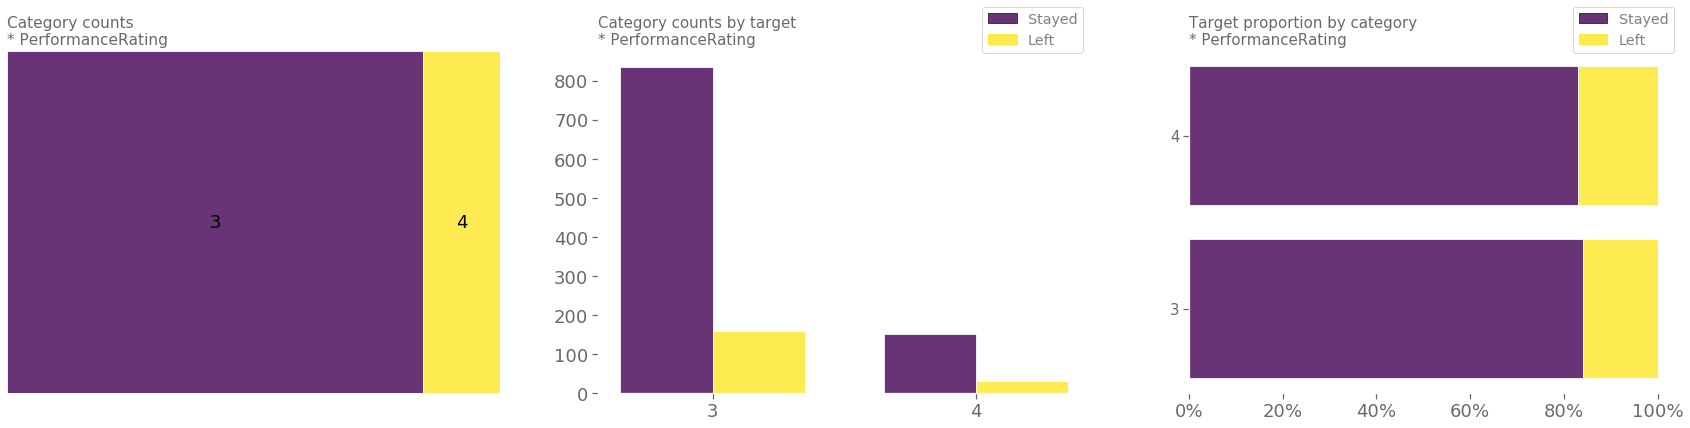

Feature summary Feature vs. target summary Target proportion 
 
 
 RelationshipSatisfaction 
 Count 
 Proportion 
 
 
 
 
 3 
 372 
 31.632653 
 
 
 4 
 338 
 28.741497 
 
 
 2 
 240 
 20.408163 
 
 
 1 
 226 
 19.217687 
 
 
 
 
 
 RelationshipSatisfaction 
 Stayed 
 Left 
 
 
 
 
 1 
 181 
 45 
 
 
 2 
 204 
 36 
 
 
 3 
 311 
 61 
 
 
 4 
 290 
 48 
 
 
 
 
 
 Class 
 1 
 2 
 3 
 4 
 
 
 
 
 Stayed 
 80.088496 
 85.0 
 83.602151 
 85.798817 
 
 
 Left 
 19.911504 
 15.0 
 16.397849 
 14.201183

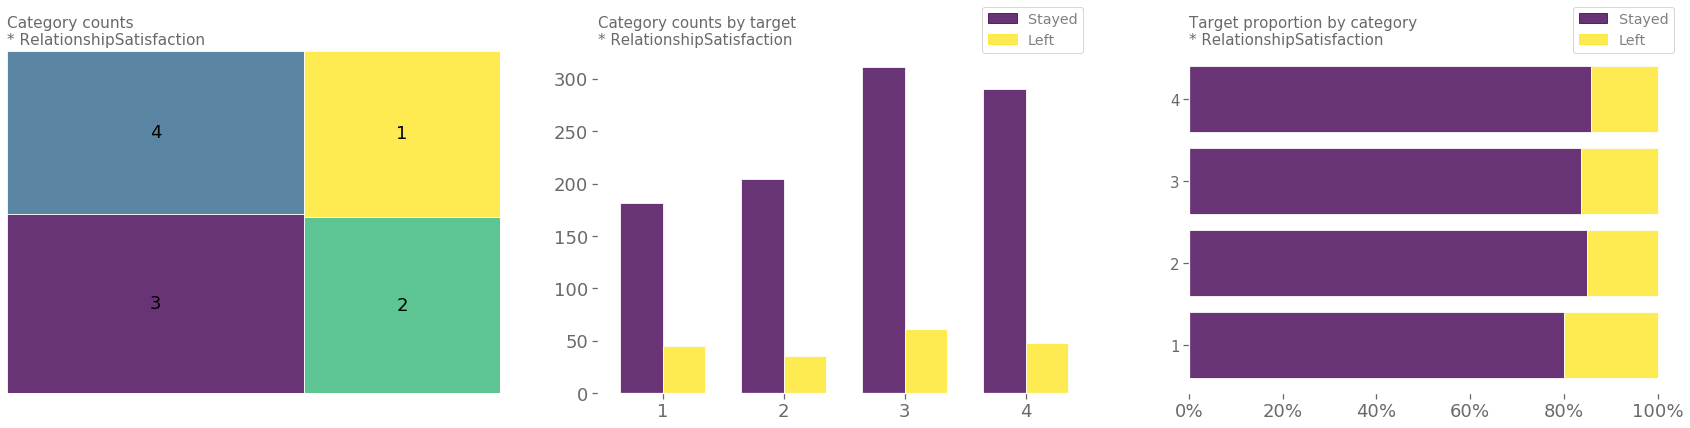

Feature summary Feature vs. target summary Target proportion 
 
 
 StockOptionLevel 
 Count 
 Proportion 
 
 
 
 
 0 
 493 
 41.921769 
 
 
 1 
 478 
 40.646259 
 
 
 2 
 132 
 11.224490 
 
 
 3 
 73 
 6.207483 
 
 
 
 
 
 StockOptionLevel 
 Stayed 
 Left 
 
 
 
 
 0 
 370 
 123 
 
 
 1 
 434 
 44 
 
 
 2 
 123 
 9 
 
 
 3 
 59 
 14 
 
 
 
 
 
 Class 
 0 
 1 
 2 
 3 
 
 
 
 
 Stayed 
 75.05071 
 90.794979 
 93.181818 
 80.821918 
 
 
 Left 
 24.94929 
 9.205021 
 6.818182 
 19.178082

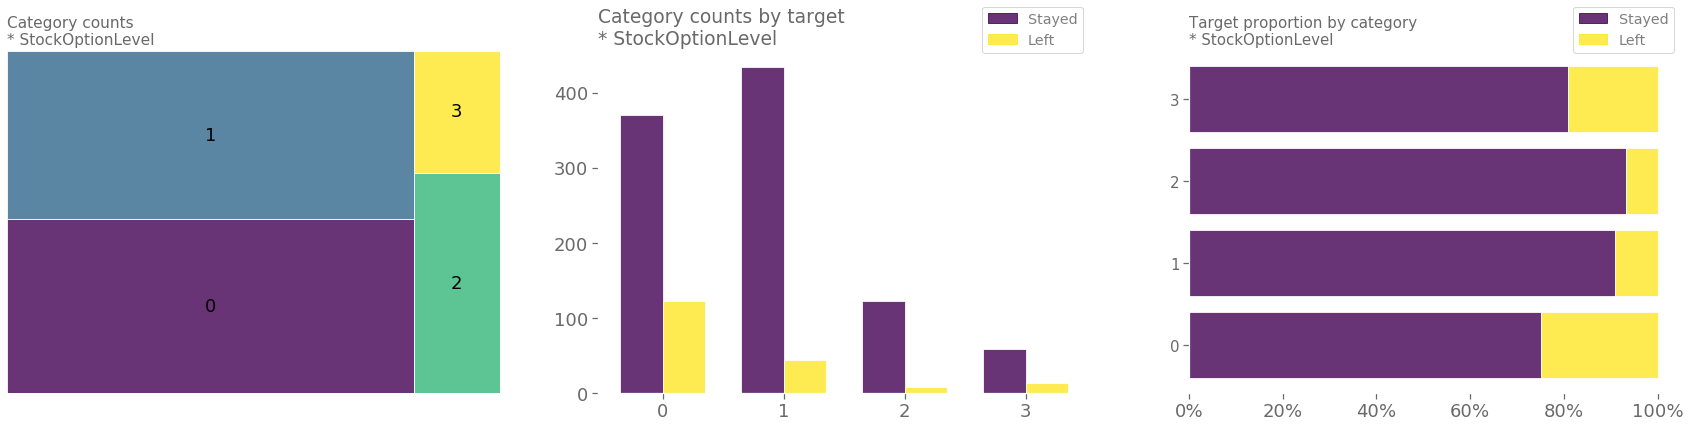

Feature summary Feature vs. target summary Target proportion 
 
 
 WorkLifeBalance 
 Count 
 Proportion 
 
 
 
 
 3 
 710 
 60.374150 
 
 
 2 
 275 
 23.384354 
 
 
 4 
 121 
 10.289116 
 
 
 1 
 70 
 5.952381 
 
 
 
 
 
 WorkLifeBalance 
 Stayed 
 Left 
 
 
 
 
 1 
 48 
 22 
 
 
 2 
 224 
 51 
 
 
 3 
 613 
 97 
 
 
 4 
 101 
 20 
 
 
 
 
 
 Class 
 1 
 2 
 3 
 4 
 
 
 
 
 Stayed 
 68.571429 
 81.454545 
 86.338028 
 83.471074 
 
 
 Left 
 31.428571 
 18.545455 
 13.661972 
 16.528926

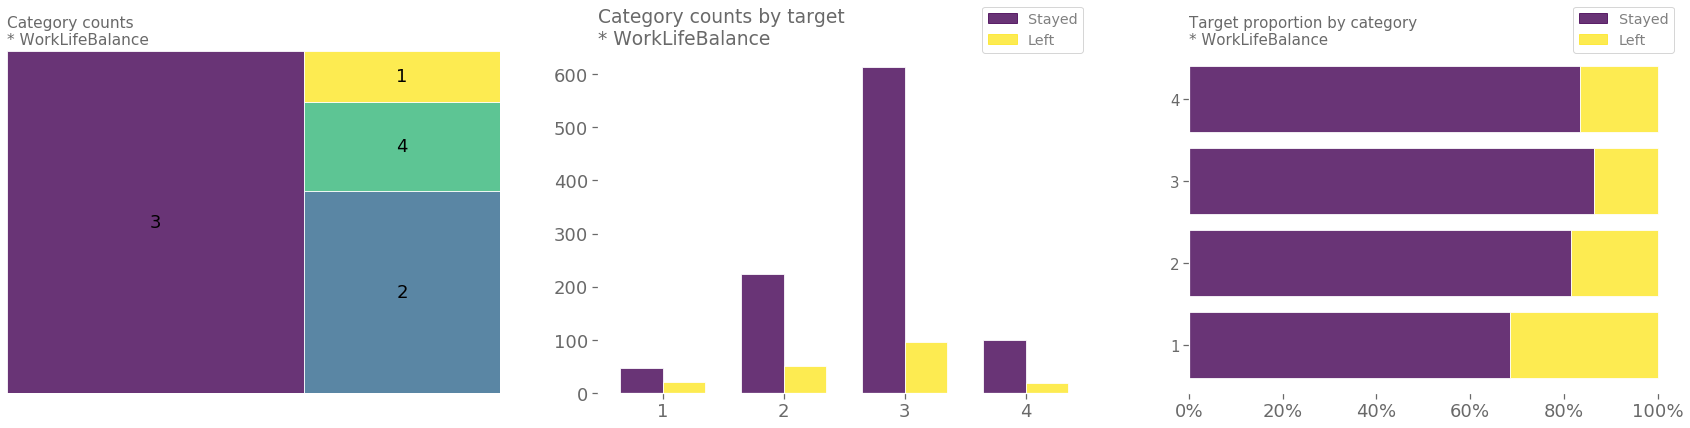

In [9]:
# number features
for feature in train.data.mlm_dtypes["category"]:
    train.eda_cat_target_cat_feat(
        feature=feature,
        level_count_cap=20,
        legend_labels=["Stayed","Left"],
        chart_scale=15
    )

## Count feature EDA

<a id = 'Count-feature-EDA'></a>

Feature summary Feature vs. target summary Target proportion 
 
 
 NumCompaniesWorked 
 Count 
 Proportion 
 
 
 
 
 1 
 410 
 34.863946 
 
 
 0 
 171 
 14.540816 
 
 
 3 
 126 
 10.714286 
 
 
 2 
 116 
 9.863946 
 
 
 4 
 103 
 8.758503 
 
 
 6 
 60 
 5.102041 
 
 
 5 
 53 
 4.506803 
 
 
 7 
 53 
 4.506803 
 
 
 9 
 45 
 3.826531 
 
 
 8 
 39 
 3.316327 
 
 
 
 
 
 NumCompaniesWorked 
 Stayed 
 Left 
 
 
 
 
 0 
 151 
 20 
 
 
 1 
 334 
 76 
 
 
 2 
 105 
 11 
 
 
 3 
 113 
 13 
 
 
 4 
 88 
 15 
 
 
 5 
 41 
 12 
 
 
 6 
 46 
 14 
 
 
 7 
 42 
 11 
 
 
 8 
 33 
 6 
 
 
 9 
 33 
 12 
 
 
 
 
 
 Class 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 Stayed 
 88.304094 
 81.463415 
 90.517241 
 89.68254 
 85.436893 
 77.358491 
 76.666667 
 79.245283 
 84.615385 
 73.333333 
 
 
 Left 
 11.695906 
 18.536585 
 9.482759 
 10.31746 
 14.563107 
 22.641509 
 23.333333 
 20.754717 
 15.384615 
 26.666667

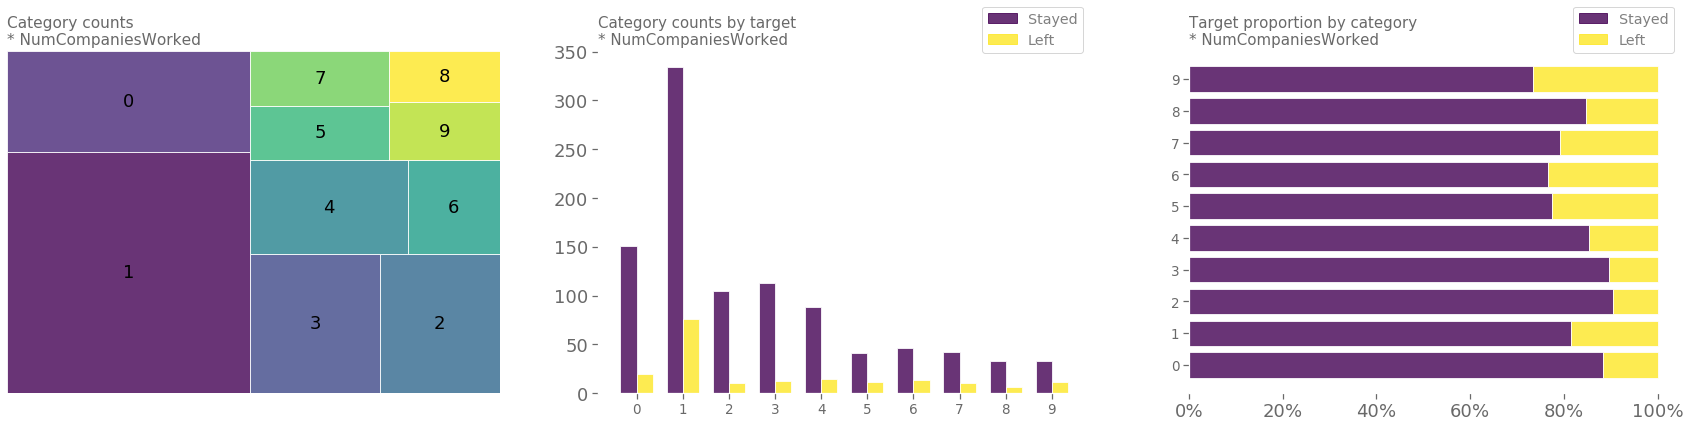

Feature summary Feature vs. target summary Target proportion 
 
 
 TrainingTimesLastYear 
 Count 
 Proportion 
 
 
 
 
 2 
 440 
 37.414966 
 
 
 3 
 392 
 33.333333 
 
 
 4 
 97 
 8.248299 
 
 
 5 
 96 
 8.163265 
 
 
 1 
 53 
 4.506803 
 
 
 6 
 53 
 4.506803 
 
 
 0 
 45 
 3.826531 
 
 
 
 
 
 TrainingTimesLastYear 
 Stayed 
 Left 
 
 
 
 
 0 
 32 
 13 
 
 
 1 
 46 
 7 
 
 
 2 
 365 
 75 
 
 
 3 
 334 
 58 
 
 
 4 
 75 
 22 
 
 
 5 
 86 
 10 
 
 
 6 
 48 
 5 
 
 
 
 
 
 Class 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 
 
 
 
 Stayed 
 71.111111 
 86.792453 
 82.954545 
 85.204082 
 77.319588 
 89.583333 
 90.566038 
 
 
 Left 
 28.888889 
 13.207547 
 17.045455 
 14.795918 
 22.680412 
 10.416667 
 9.433962

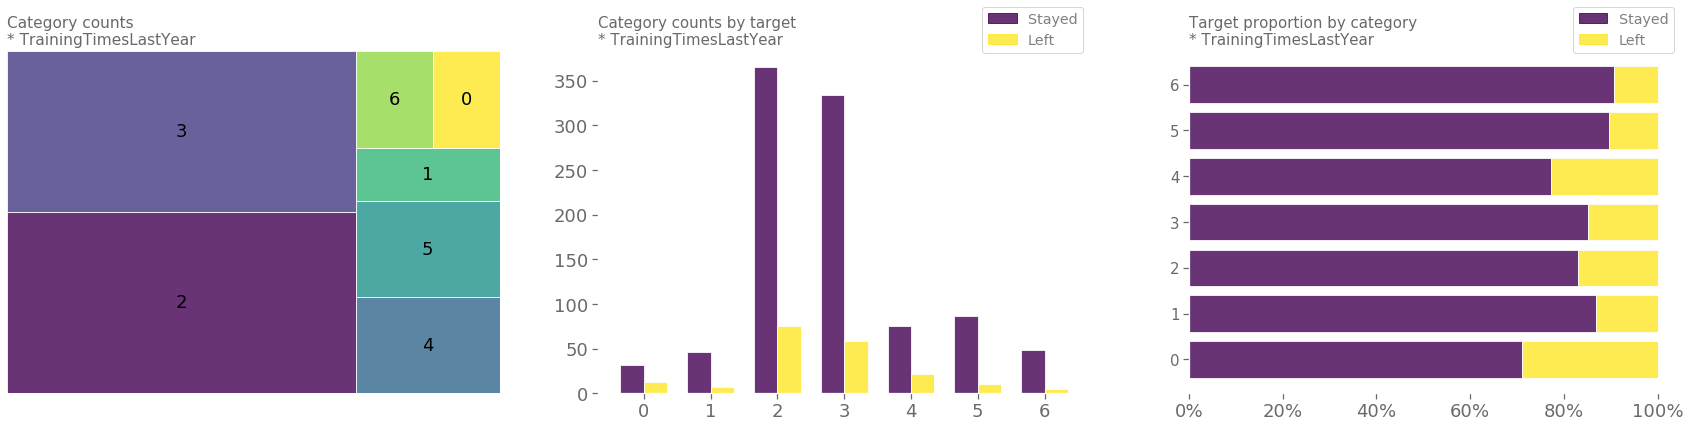

In [10]:
# number features
for feature in train.data.mlm_dtypes["count"]:
    train.eda_cat_target_cat_feat(
        feature=feature,
        level_count_cap=20,
        legend_labels=["Stayed","Left"],
        chart_scale=15
    )

## Continuous feature EDA

<a id = 'Continuous-feature-EDA'></a>

Feature summary Feature vs. target summary Statistical test 
 
 
 
 Age 
 
 
 
 
 count 
 1176.000000 
 
 
 mean 
 37.077381 
 
 
 std 
 9.157904 
 
 
 min 
 18.000000 
 
 
 25% 
 30.000000 
 
 
 50% 
 36.000000 
 
 
 75% 
 43.000000 
 
 
 max 
 60.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.452440 
 
 
 kurtosis 
 -0.395134 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Stayed 
 986.0 
 83.843537 
 37.600406 
 8.959259 
 
 
 Left 
 190.0 
 16.156463 
 34.363158 
 9.659994 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 4.498 
 0.0

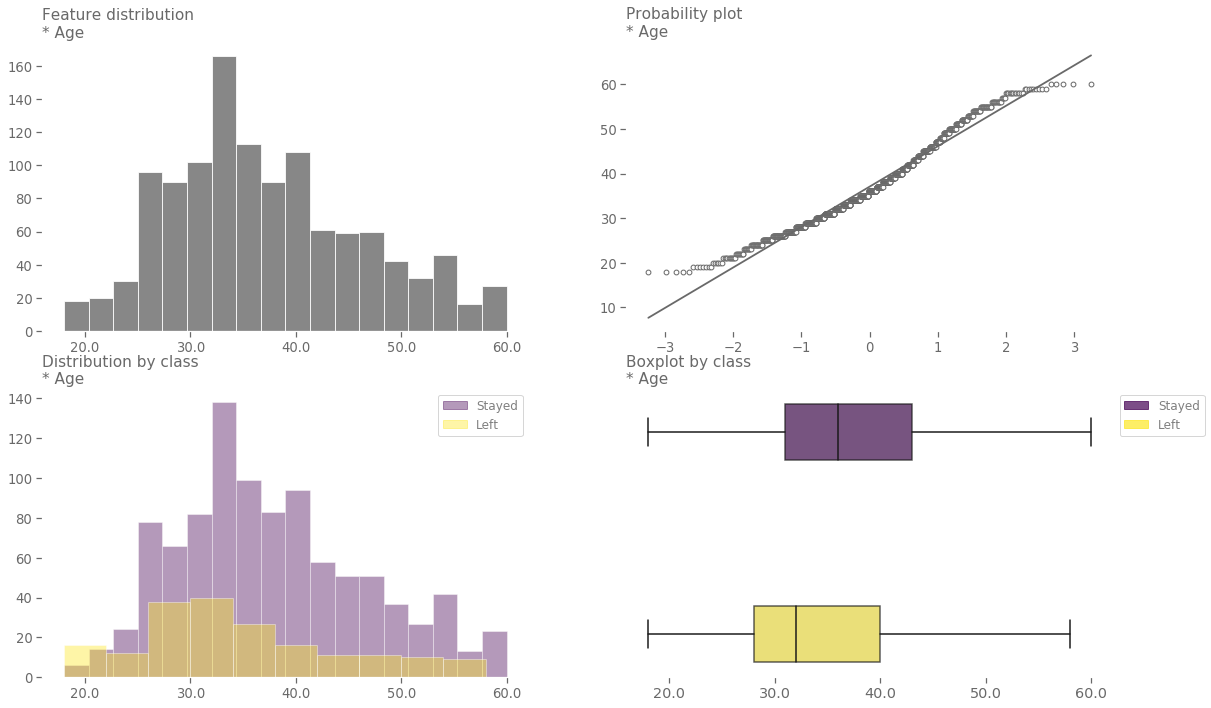

Feature summary Feature vs. target summary Statistical test 
 
 
 
 DailyRate 
 
 
 
 
 count 
 1176.000000 
 
 
 mean 
 800.568878 
 
 
 std 
 401.853426 
 
 
 min 
 102.000000 
 
 
 25% 
 465.750000 
 
 
 50% 
 792.500000 
 
 
 75% 
 1153.250000 
 
 
 max 
 1499.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.010010 
 
 
 kurtosis 
 -1.201633 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Stayed 
 986.0 
 83.843537 
 809.455375 
 402.43716 
 
 
 Left 
 190.0 
 16.156463 
 754.452632 
 394.54190 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 1.729 
 0.0838

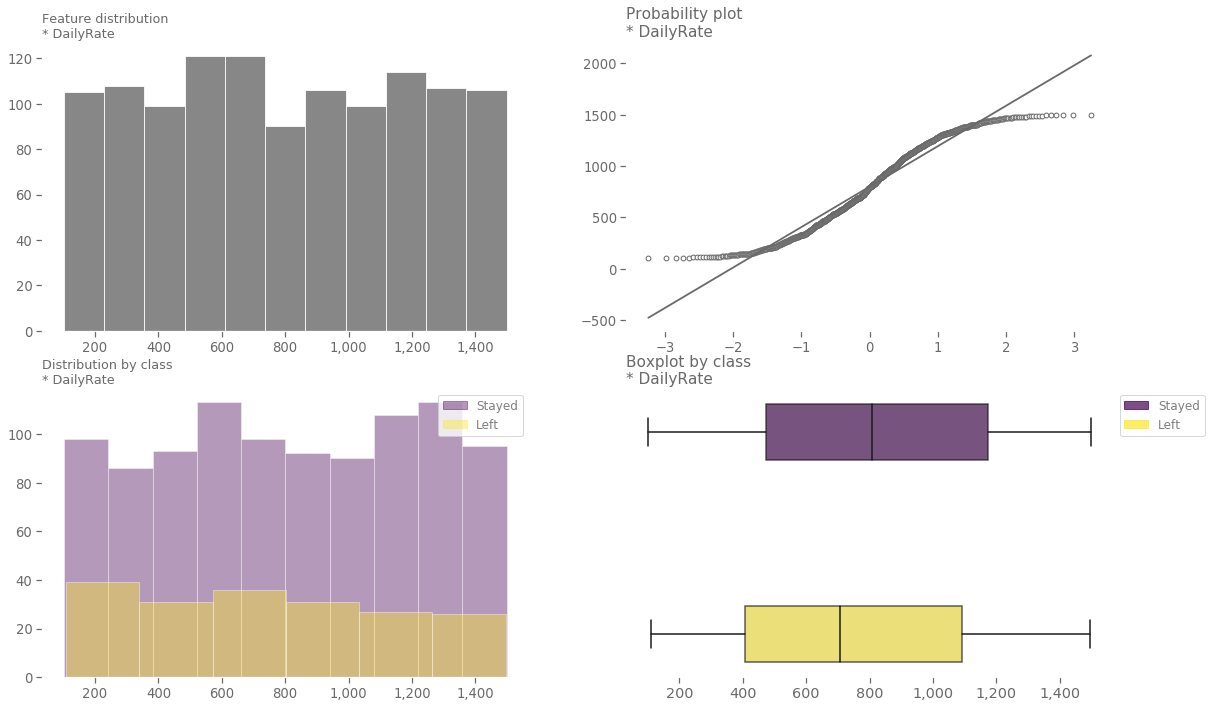

Feature summary Feature vs. target summary Statistical test 
 
 
 
 DistanceFromHome 
 
 
 
 
 count 
 1176.000000 
 
 
 mean 
 9.487245 
 
 
 std 
 8.307075 
 
 
 min 
 1.000000 
 
 
 25% 
 2.000000 
 
 
 50% 
 7.000000 
 
 
 75% 
 15.000000 
 
 
 max 
 29.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.885270 
 
 
 kurtosis 
 -0.422887 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Stayed 
 986.0 
 83.843537 
 9.154158 
 8.210625 
 
 
 Left 
 190.0 
 16.156463 
 11.215789 
 8.564355 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 -3.1442 
 0.0017

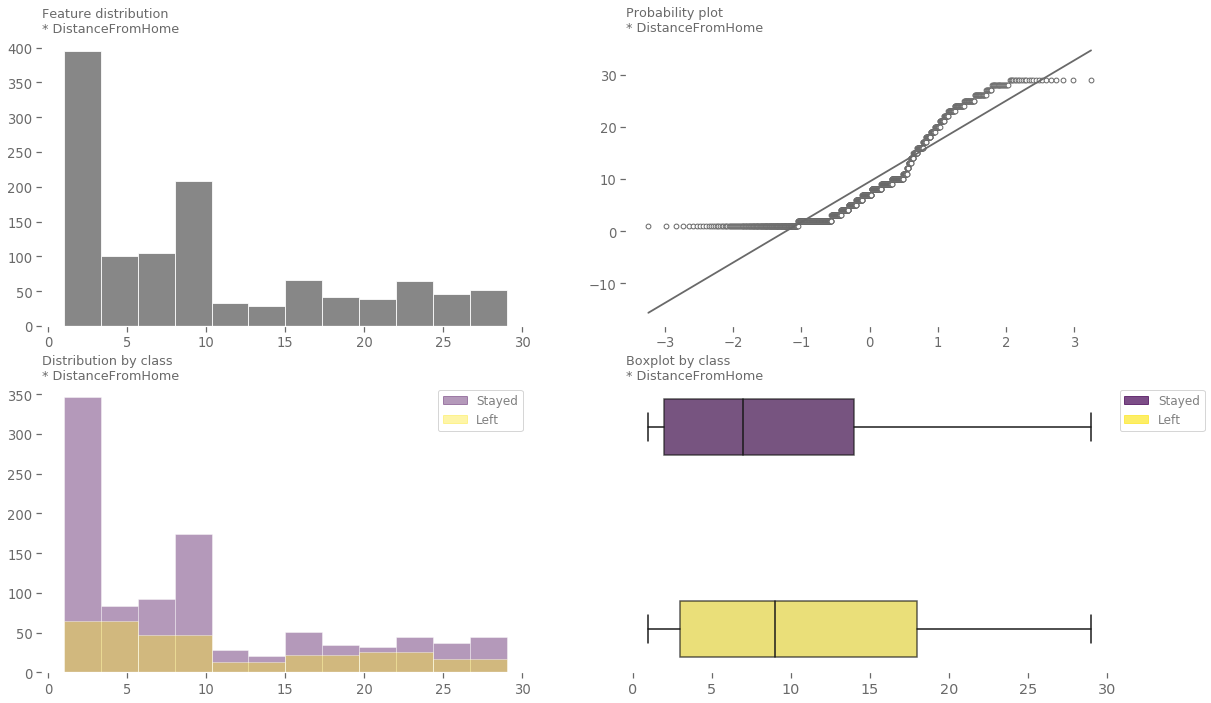

Feature summary Feature vs. target summary Statistical test 
 
 
 
 HourlyRate 
 
 
 
 
 count 
 1176.000000 
 
 
 mean 
 65.978741 
 
 
 std 
 20.289028 
 
 
 min 
 30.000000 
 
 
 25% 
 49.000000 
 
 
 50% 
 66.000000 
 
 
 75% 
 84.000000 
 
 
 max 
 100.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 -0.033380 
 
 
 kurtosis 
 -1.184947 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Stayed 
 986.0 
 83.843537 
 66.116633 
 20.427023 
 
 
 Left 
 190.0 
 16.156463 
 65.263158 
 19.486141 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 0.5308 
 0.5956

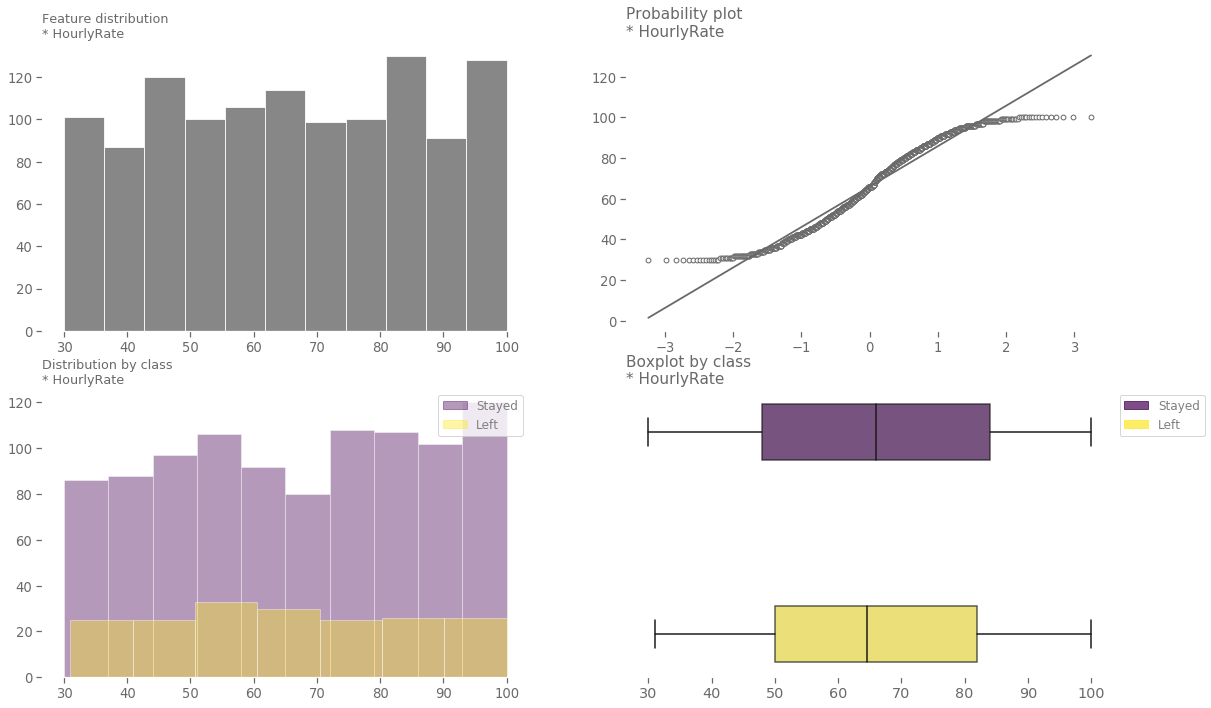

Feature summary Feature vs. target summary Statistical test 
 
 
 
 MonthlyIncome 
 
 
 
 
 count 
 1176.000000 
 
 
 mean 
 6547.003401 
 
 
 std 
 4702.602716 
 
 
 min 
 1051.000000 
 
 
 25% 
 2936.000000 
 
 
 50% 
 4919.000000 
 
 
 75% 
 8516.000000 
 
 
 max 
 19999.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 1.340790 
 
 
 kurtosis 
 0.927270 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Stayed 
 986.0 
 83.843537 
 6882.462475 
 4835.029076 
 
 
 Left 
 190.0 
 16.156463 
 4806.147368 
 3439.336227 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 5.6454 
 0.0

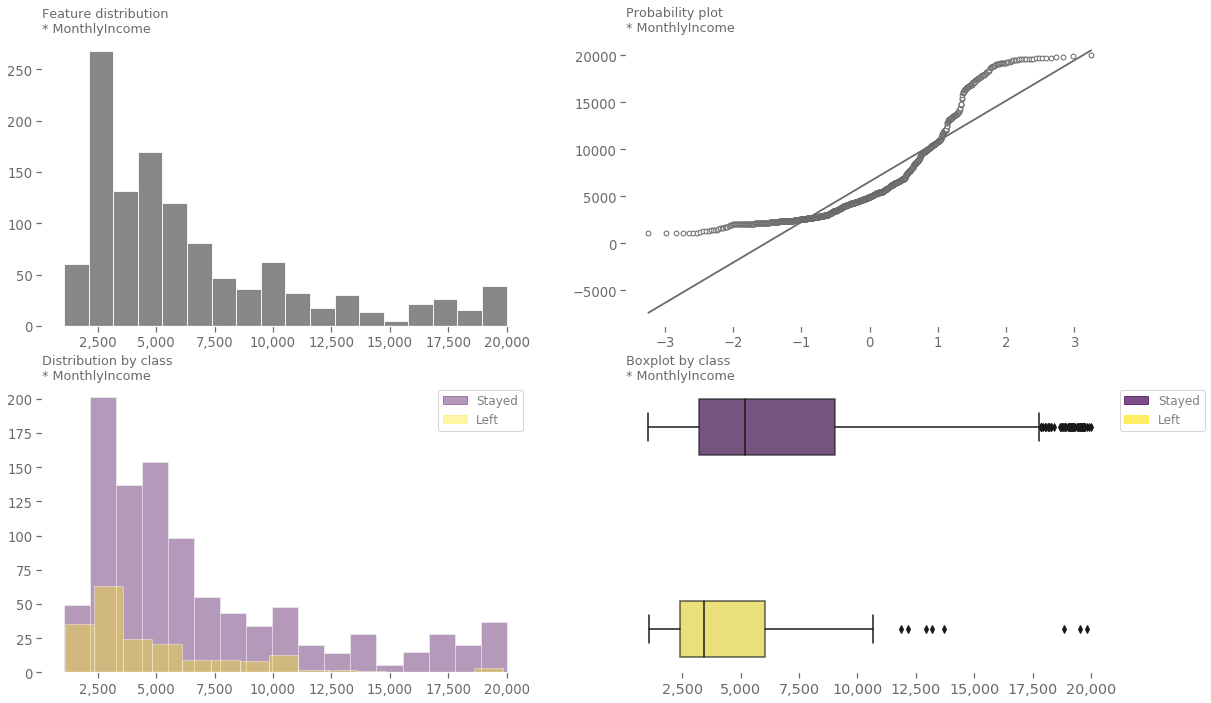

Feature summary Feature vs. target summary Statistical test 
 
 
 
 MonthlyRate 
 
 
 
 
 count 
 1176.000000 
 
 
 mean 
 14129.690476 
 
 
 std 
 7145.159970 
 
 
 min 
 2094.000000 
 
 
 25% 
 7764.250000 
 
 
 50% 
 13936.000000 
 
 
 75% 
 20364.000000 
 
 
 max 
 26997.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.063700 
 
 
 kurtosis 
 -1.231412 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Stayed 
 986.0 
 83.843537 
 14077.681542 
 7166.307652 
 
 
 Left 
 190.0 
 16.156463 
 14399.589474 
 7009.073393 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 -0.5685 
 0.5697

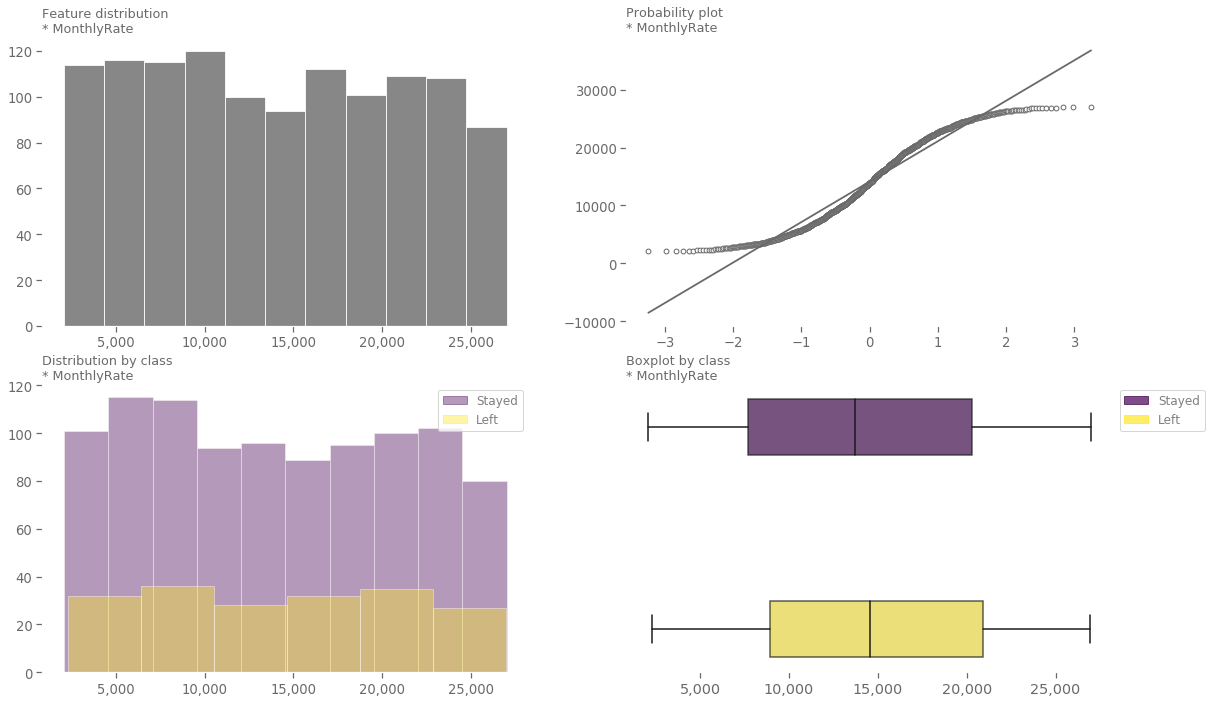

Feature summary Feature vs. target summary Statistical test 
 
 
 
 PercentSalaryHike 
 
 
 
 
 count 
 1176.000000 
 
 
 mean 
 15.225340 
 
 
 std 
 3.659937 
 
 
 min 
 11.000000 
 
 
 25% 
 12.000000 
 
 
 50% 
 14.000000 
 
 
 75% 
 18.000000 
 
 
 max 
 25.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.803560 
 
 
 kurtosis 
 -0.363239 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Stayed 
 986.0 
 83.843537 
 15.212982 
 3.642948 
 
 
 Left 
 190.0 
 16.156463 
 15.289474 
 3.736787 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 -0.2637 
 0.792

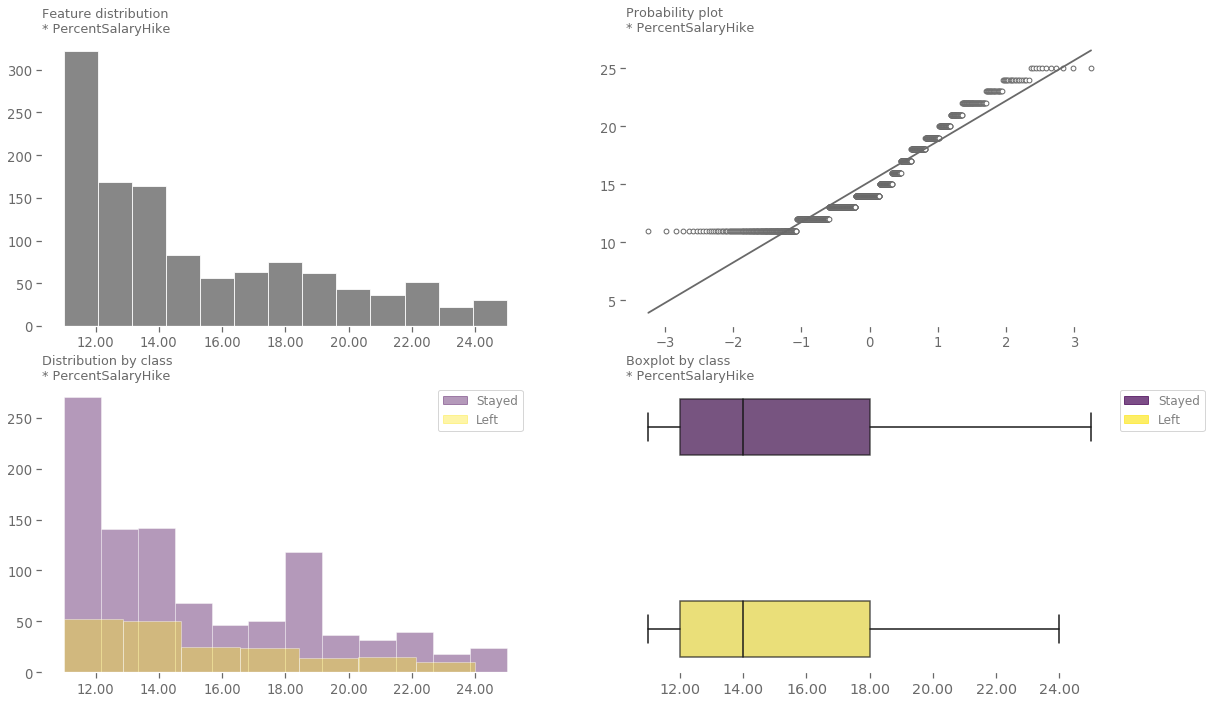

Feature summary Feature vs. target summary Statistical test 
 
 
 
 TotalWorkingYears 
 
 
 
 
 count 
 1176.000000 
 
 
 mean 
 11.335034 
 
 
 std 
 7.847157 
 
 
 min 
 0.000000 
 
 
 25% 
 6.000000 
 
 
 50% 
 10.000000 
 
 
 75% 
 15.000000 
 
 
 max 
 40.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 1.143690 
 
 
 kurtosis 
 0.936589 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Stayed 
 986.0 
 83.843537 
 11.878296 
 7.866753 
 
 
 Left 
 190.0 
 16.156463 
 8.515789 
 7.083507 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 5.4746 
 0.0

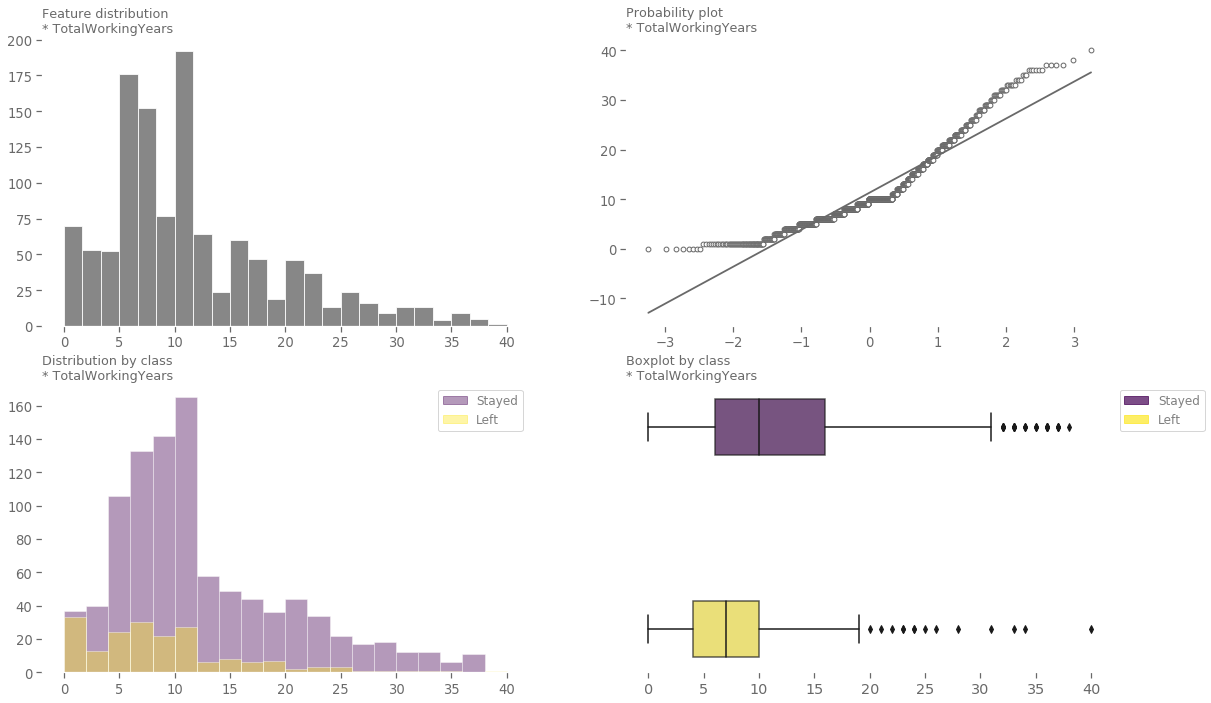

Feature summary Feature vs. target summary Statistical test 
 
 
 
 YearsAtCompany 
 
 
 
 
 count 
 1176.000000 
 
 
 mean 
 7.045918 
 
 
 std 
 6.165347 
 
 
 min 
 0.000000 
 
 
 25% 
 3.000000 
 
 
 50% 
 5.000000 
 
 
 75% 
 10.000000 
 
 
 max 
 40.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 1.816890 
 
 
 kurtosis 
 4.245375 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Stayed 
 986.0 
 83.843537 
 7.381339 
 6.127666 
 
 
 Left 
 190.0 
 16.156463 
 5.305263 
 6.049922 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 4.2813 
 0.0

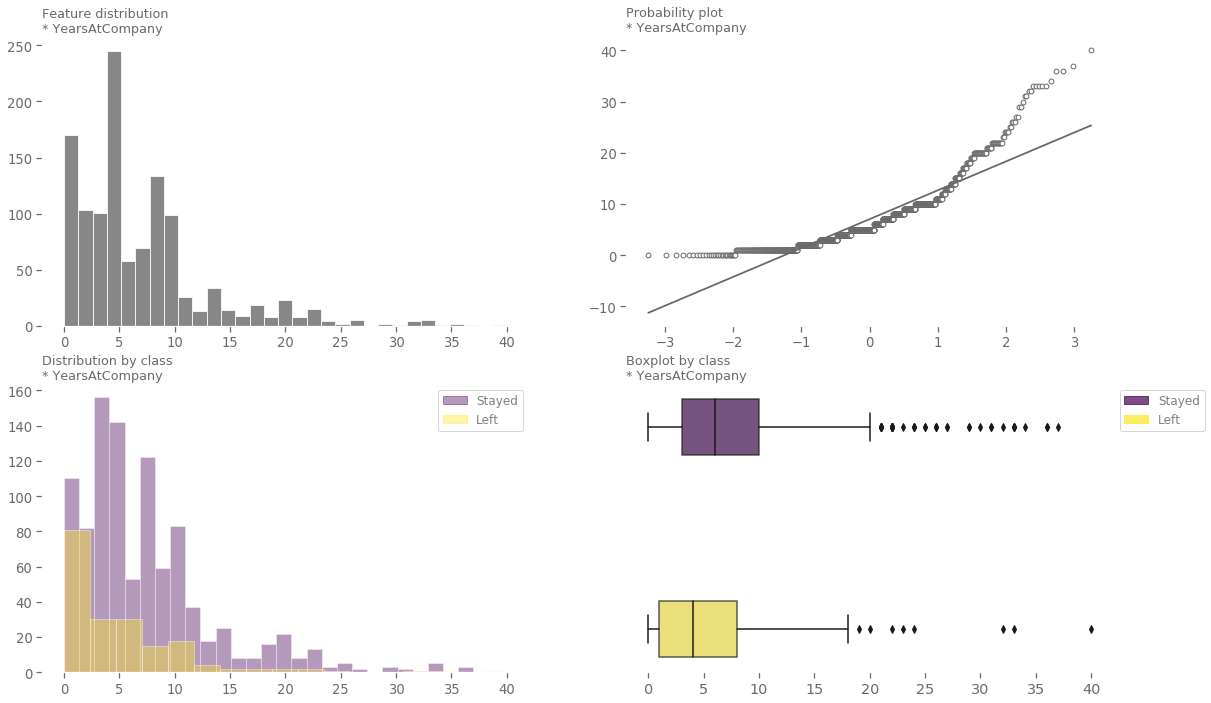

Feature summary Feature vs. target summary Statistical test 
 
 
 
 YearsInCurrentRole 
 
 
 
 
 count 
 1176.000000 
 
 
 mean 
 4.285714 
 
 
 std 
 3.635990 
 
 
 min 
 0.000000 
 
 
 25% 
 2.000000 
 
 
 50% 
 3.000000 
 
 
 75% 
 7.000000 
 
 
 max 
 18.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.906980 
 
 
 kurtosis 
 0.481494 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Stayed 
 986.0 
 83.843537 
 4.538540 
 3.661797 
 
 
 Left 
 190.0 
 16.156463 
 2.973684 
 3.181251 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 5.4992 
 0.0

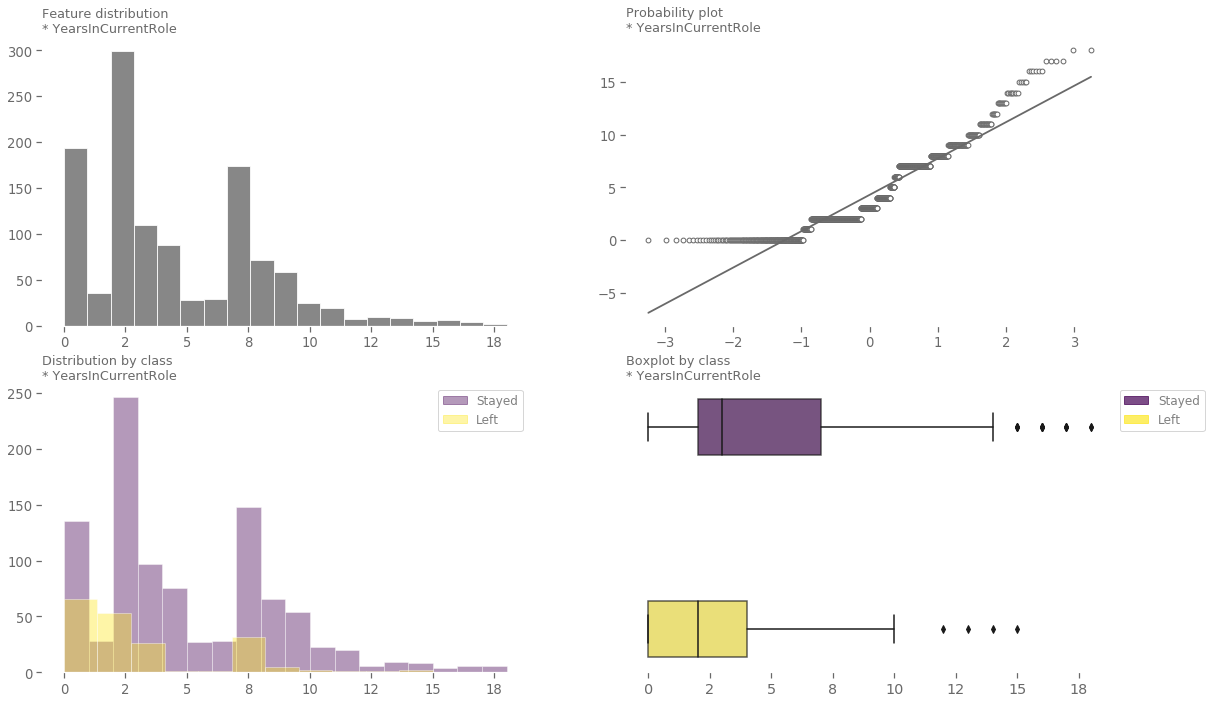

Feature summary Feature vs. target summary Statistical test 
 
 
 
 YearsSinceLastPromotion 
 
 
 
 
 count 
 1176.000000 
 
 
 mean 
 2.235544 
 
 
 std 
 3.260825 
 
 
 min 
 0.000000 
 
 
 25% 
 0.000000 
 
 
 50% 
 1.000000 
 
 
 75% 
 3.000000 
 
 
 max 
 15.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 1.958010 
 
 
 kurtosis 
 3.480049 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Stayed 
 986.0 
 83.843537 
 2.284990 
 3.275225 
 
 
 Left 
 190.0 
 16.156463 
 1.978947 
 3.163872 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 1.1848 
 0.2361

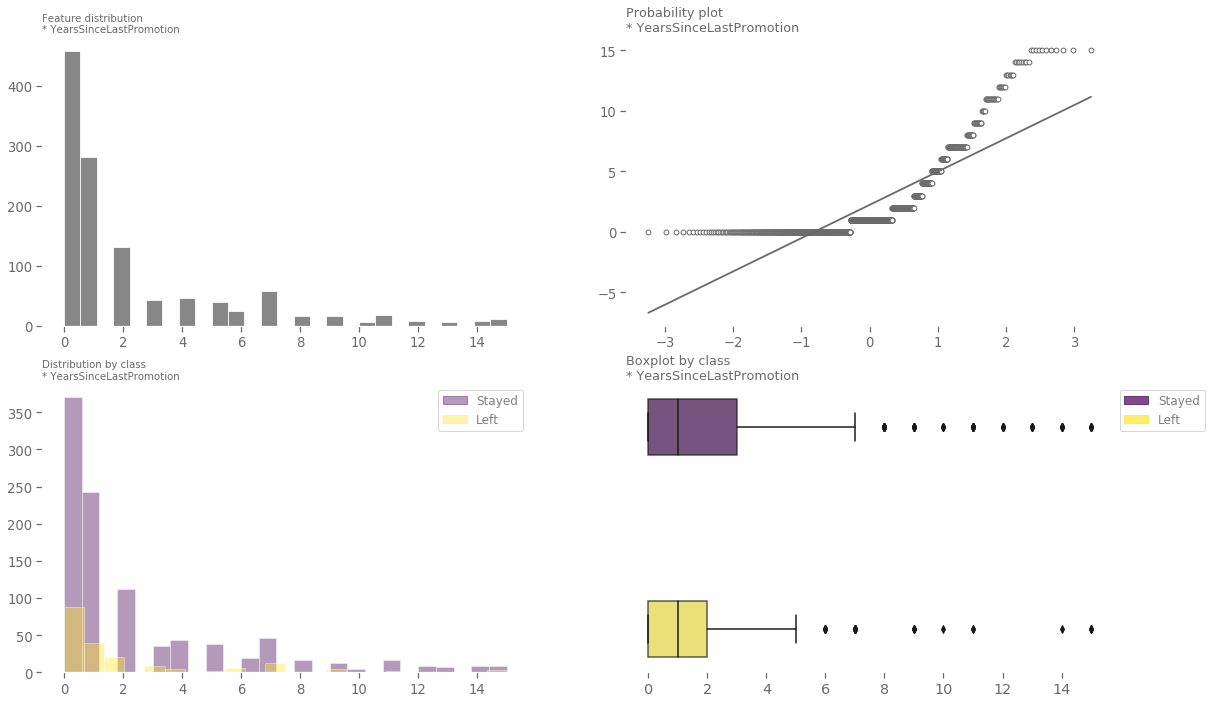

Feature summary Feature vs. target summary Statistical test 
 
 
 
 YearsWithCurrManager 
 
 
 
 
 count 
 1176.000000 
 
 
 mean 
 4.147109 
 
 
 std 
 3.593795 
 
 
 min 
 0.000000 
 
 
 25% 
 2.000000 
 
 
 50% 
 3.000000 
 
 
 75% 
 7.000000 
 
 
 max 
 17.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.853860 
 
 
 kurtosis 
 0.269510 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Stayed 
 986.0 
 83.843537 
 4.381339 
 3.626393 
 
 
 Left 
 190.0 
 16.156463 
 2.931579 
 3.140659 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 5.1465 
 0.0

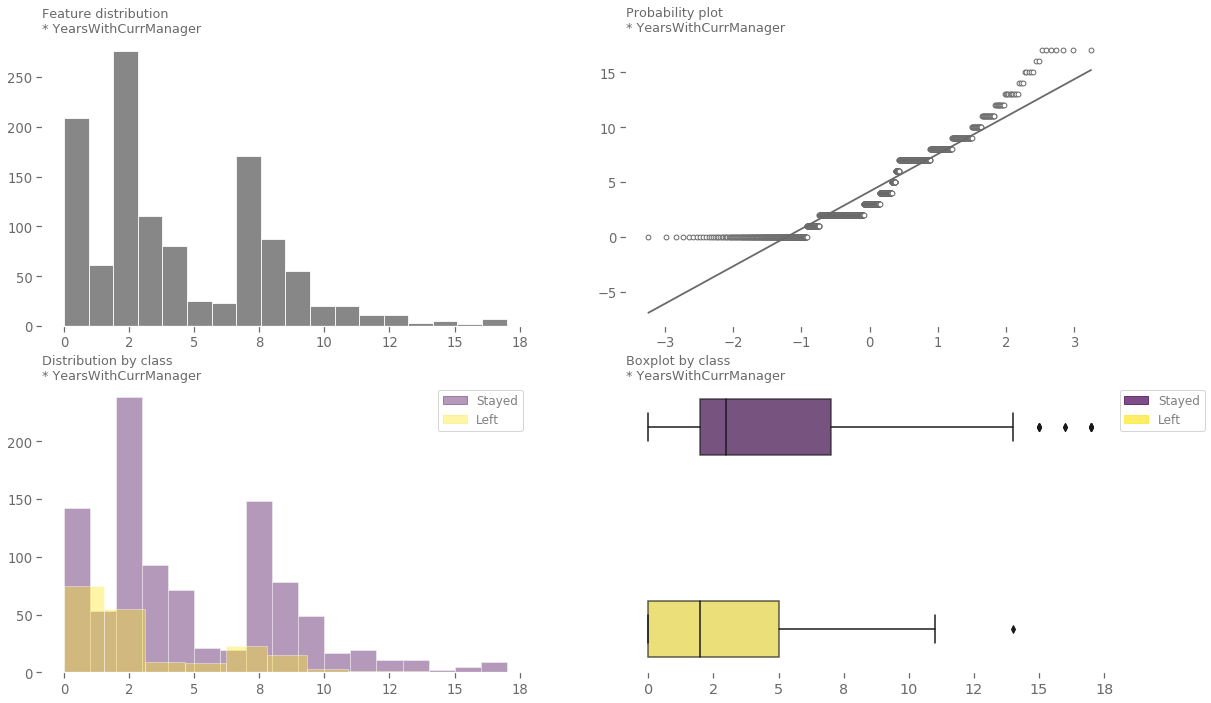

In [11]:
# number features
for feature in train.data.mlm_dtypes["continuous"]:
    train.eda_cat_target_num_feat(
        feature=feature,
#         outliers_out_of_scope=10,
        legend_labels=["Stayed","Left"],
        chart_scale=12
    )

##### Correlation

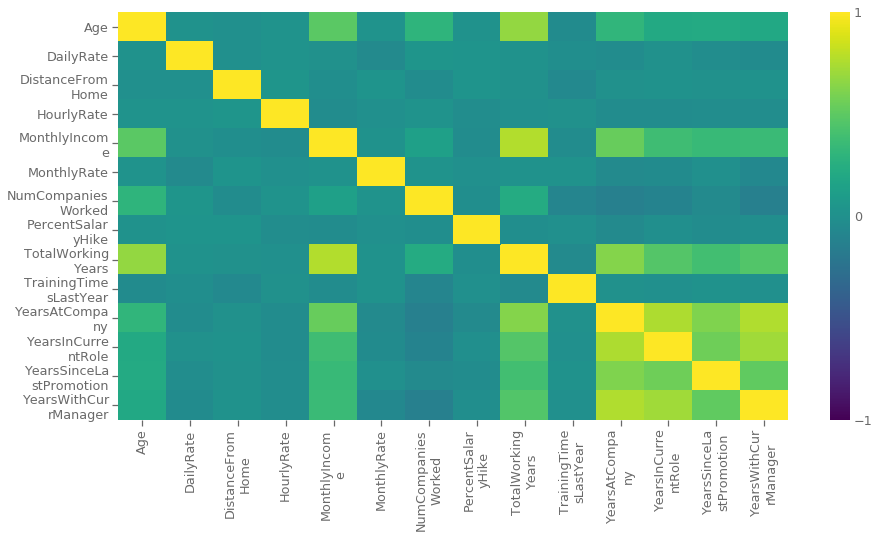

In [12]:
# correlation heat map
p = PrettierPlot()
ax = p.make_canvas()
p.corr_heatmap(df=train.data, annot=False, ax=ax)

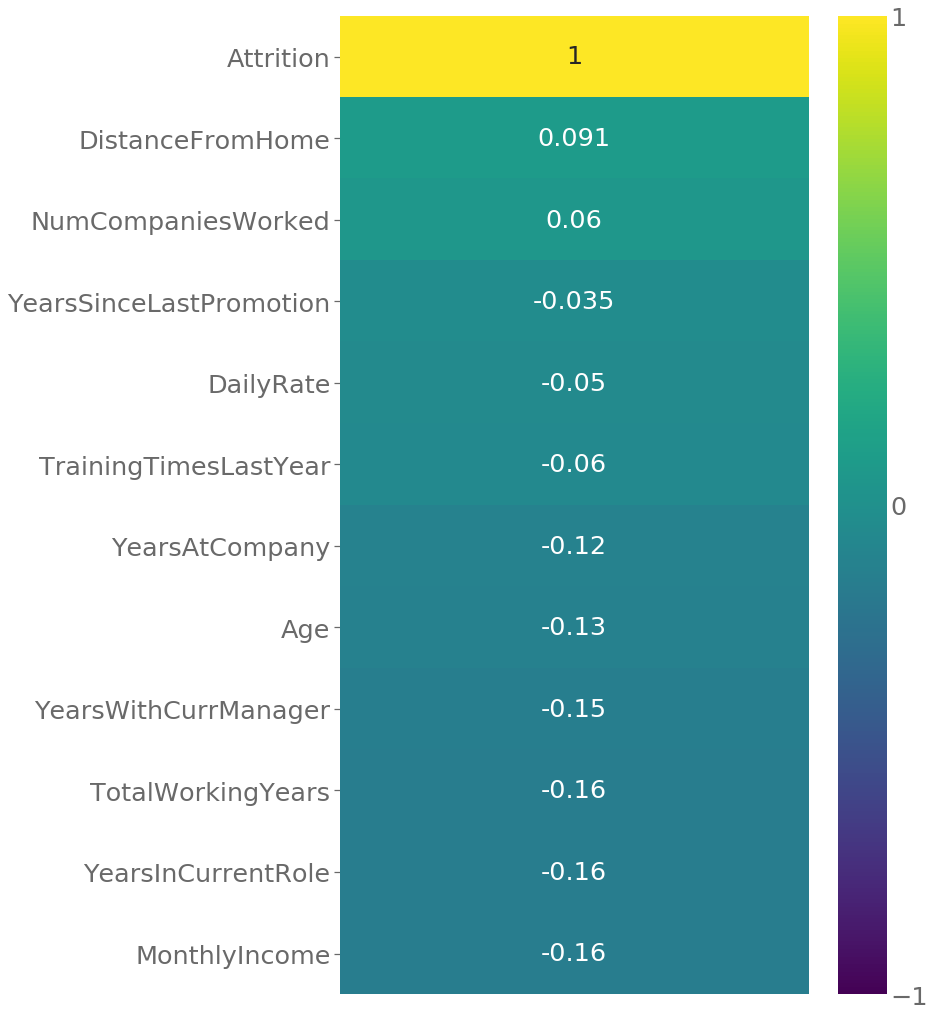

In [13]:
# correlation heat map with most highly correlated features relative to the target
p = PrettierPlot(plot_orientation='tall')
ax = p.make_canvas()
p.corr_heatmap_target(
    df=train.data, target=train.target, thresh=0.02, annot=True, ax=ax
)

<Figure size 864x432 with 0 Axes>

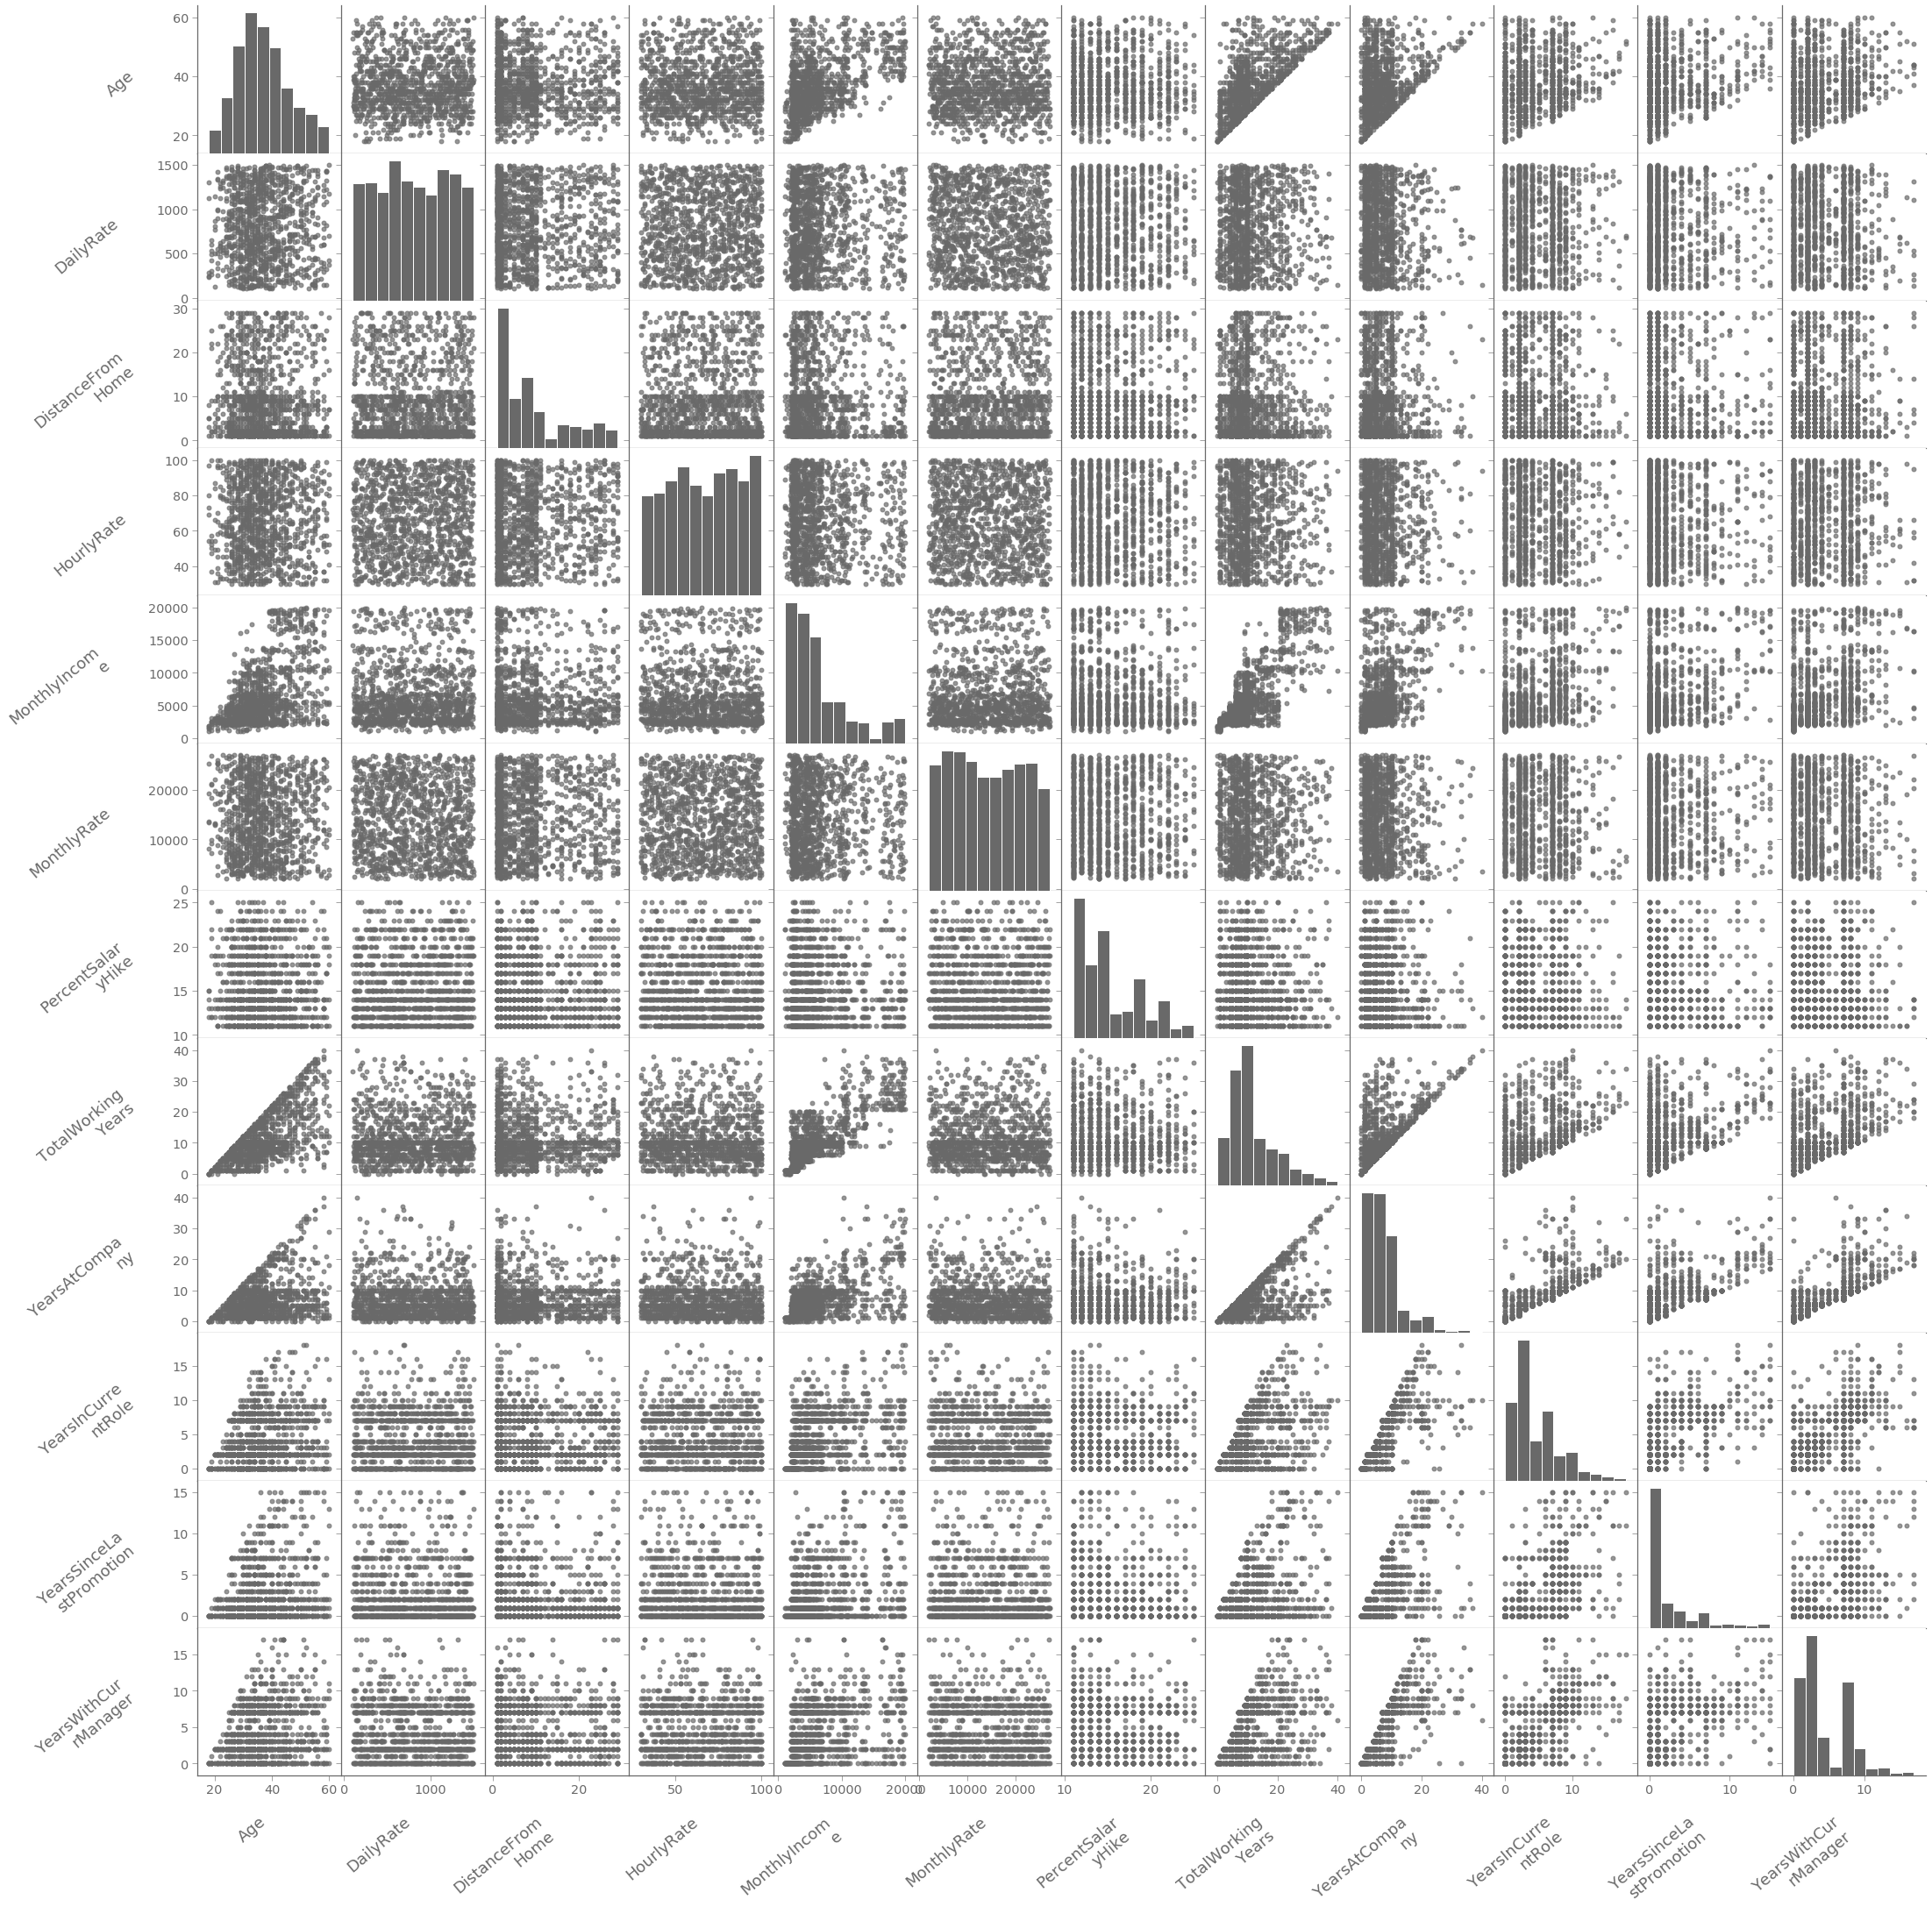

In [14]:
# pair plot
p = PrettierPlot(chart_scale=12)
p.pair_plot(df=train.data, columns=train.data.mlm_dtypes['continuous'], diag_kind="auto")

<Figure size 864x432 with 0 Axes>

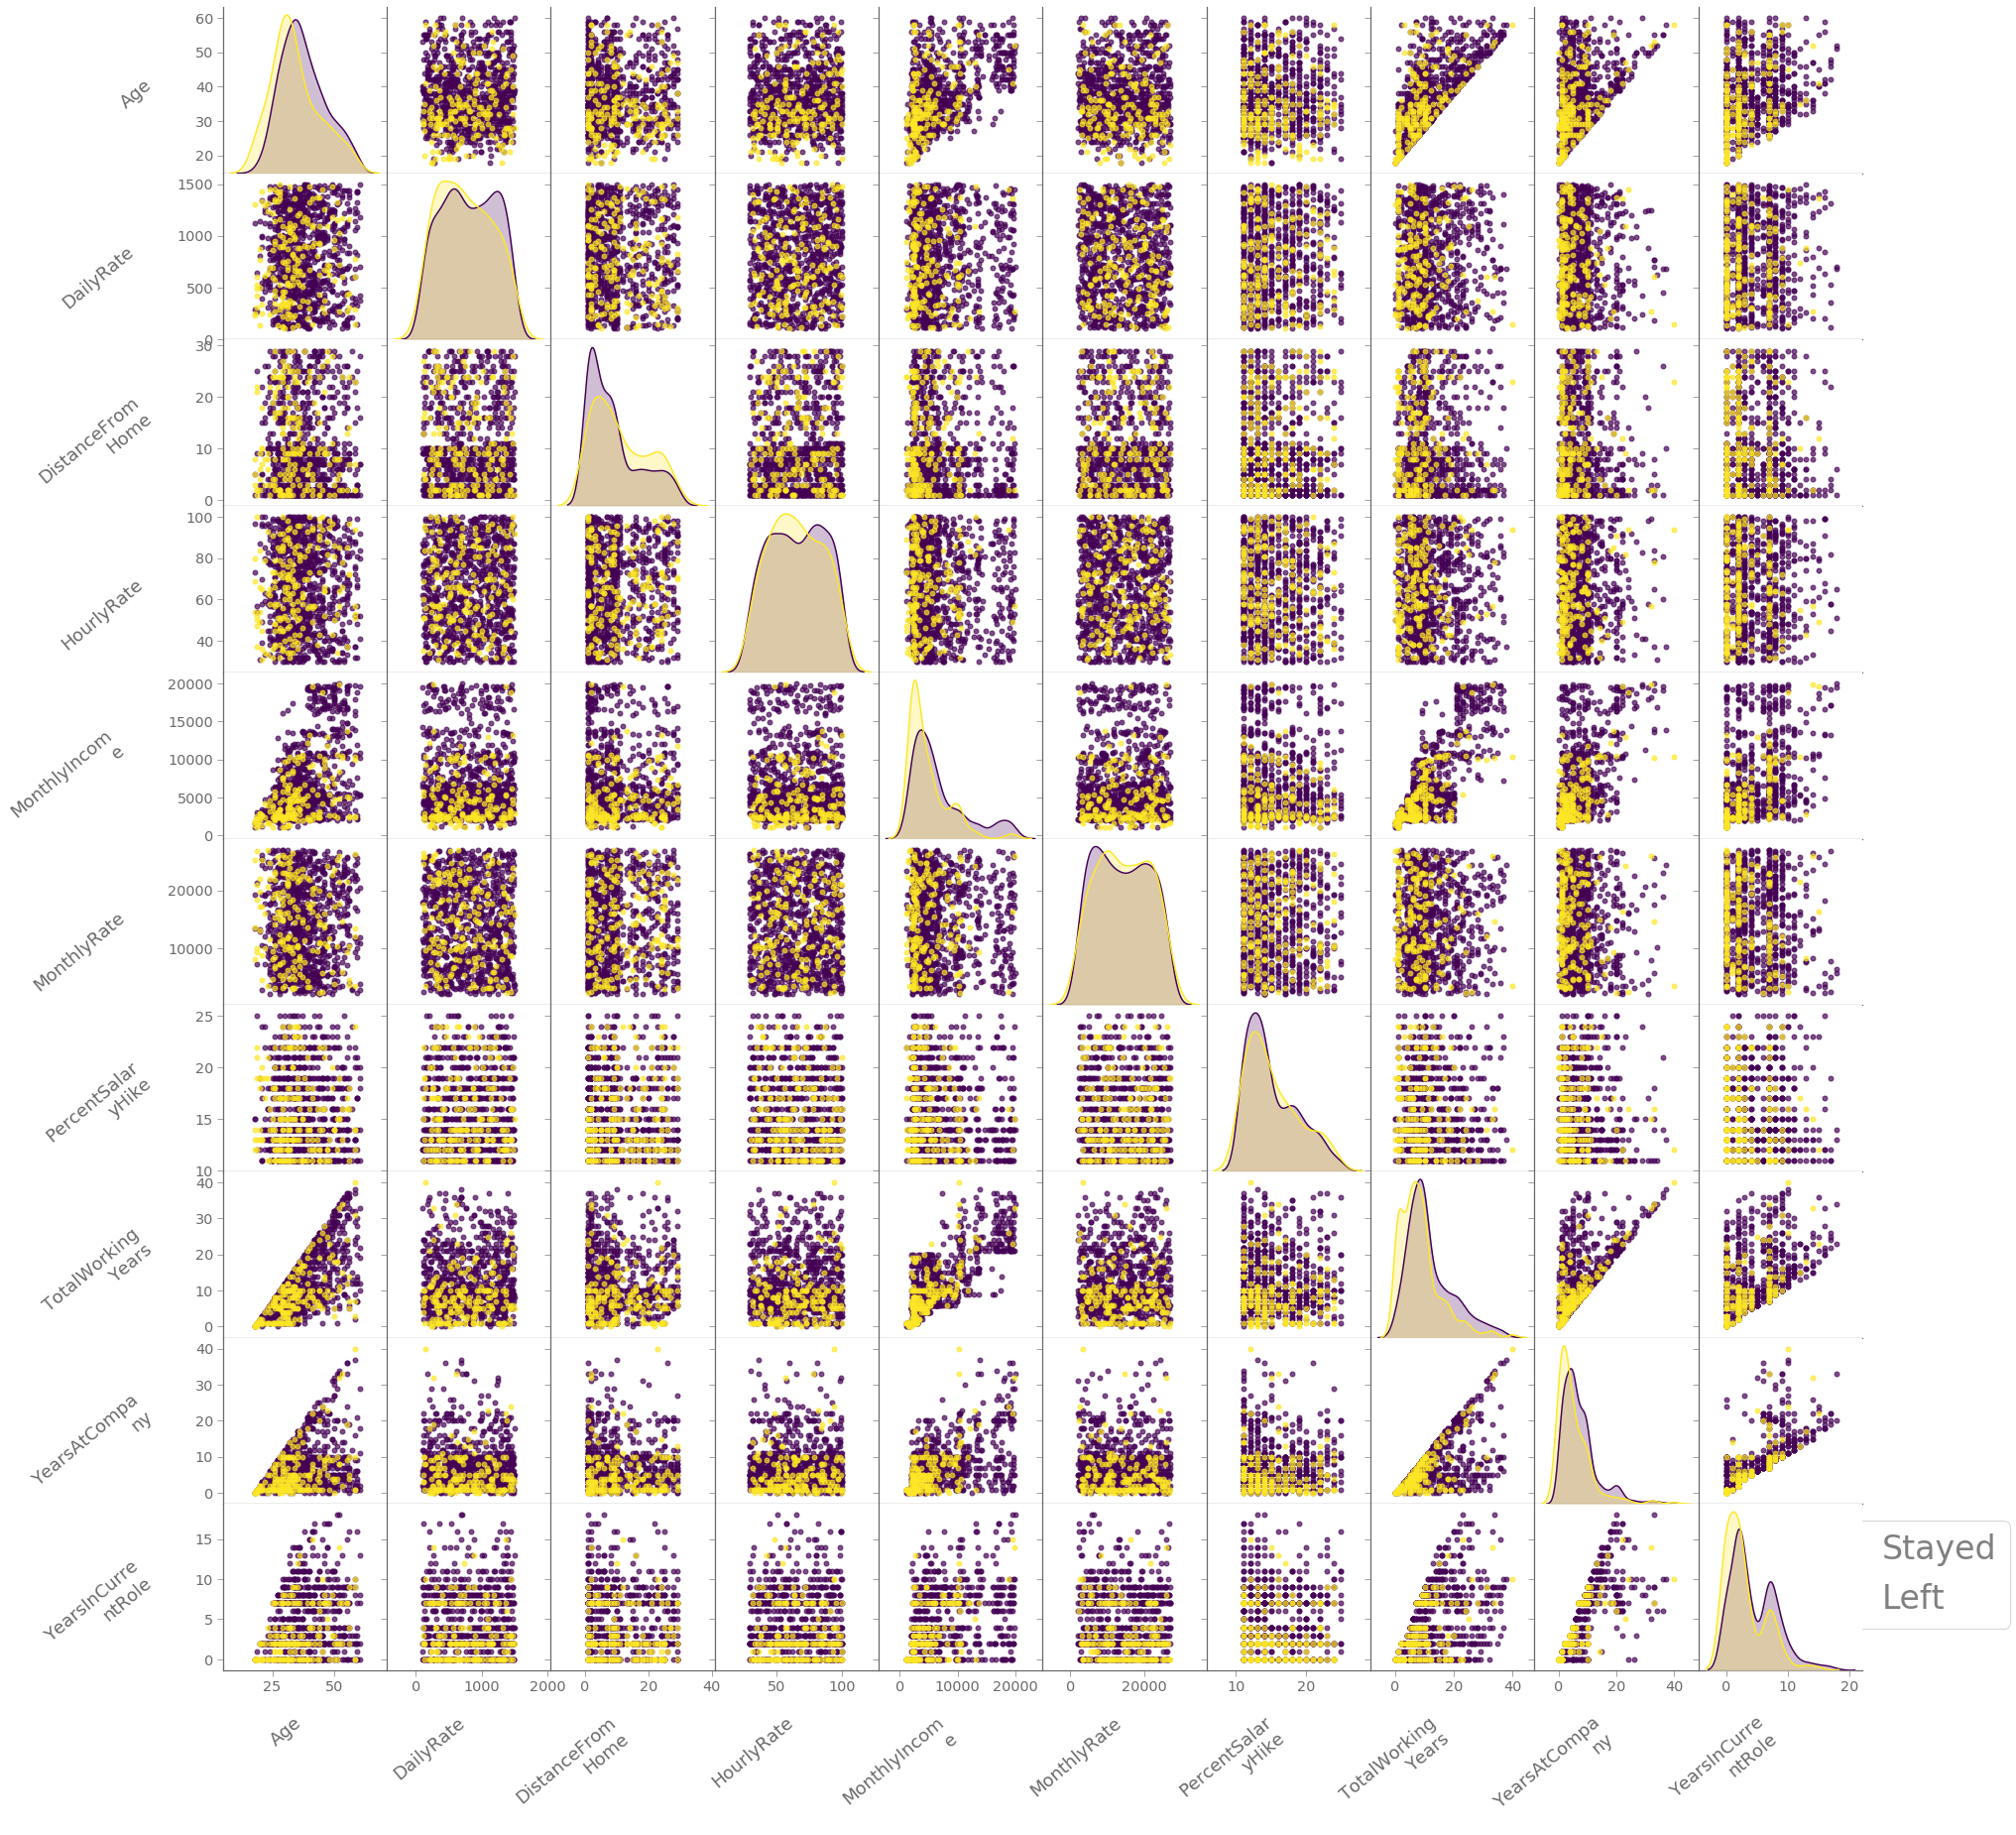

In [15]:
# pair plot
p = PrettierPlot(chart_scale=12)
p.pair_plot(
    df=train.data.dropna(),
    diag_kind="kde",
    target=train.target,
    columns=train.data.mlm_dtypes['continuous'][:10],
    legend_labels=["Stayed","Left"],
    bbox=(2.0, 0.0),
)

## Faceting

<a id = 'Faceting'></a>

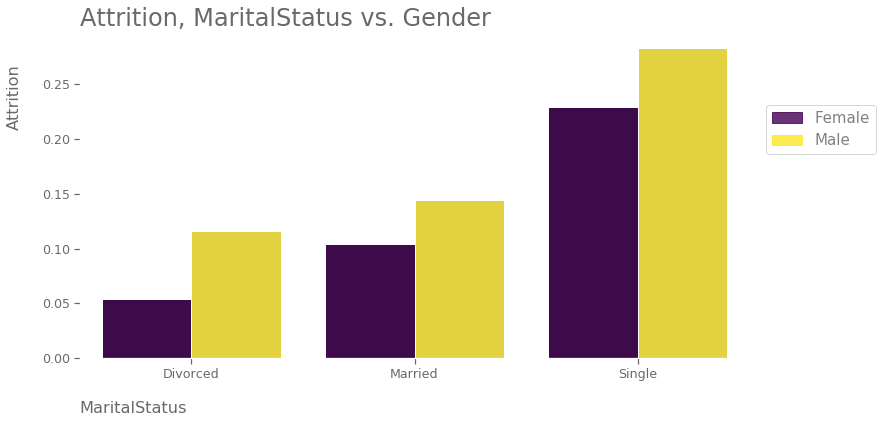

In [16]:
# facet MaritalStatus vs. Gender
p = PrettierPlot(chart_scale=12)
ax = p.make_canvas(title="Attrition, MaritalStatus vs. Gender", y_shift=0.7)
p.facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="MaritalStatus",
    y=train.target.name,
    split="Gender",
    y_units="fff",
    bbox = (1.2, 0.8),
    ax=ax,
)

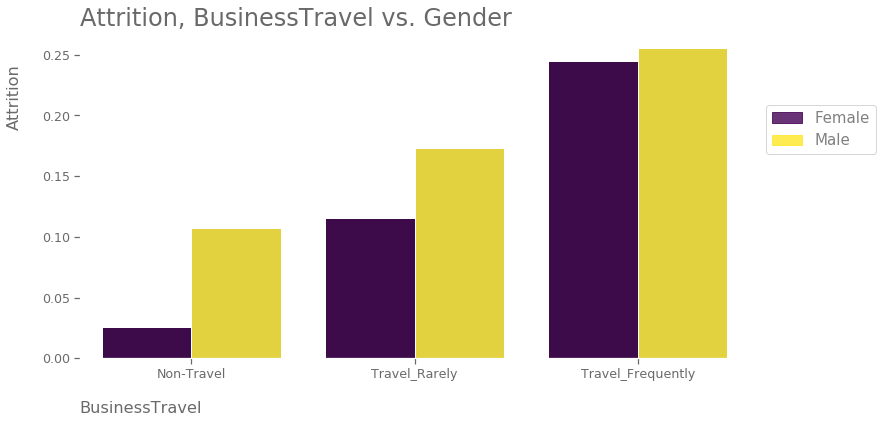

In [17]:
# facet MaritalStatus vs. Gender
p = PrettierPlot(chart_scale=12)
ax = p.make_canvas(title="Attrition, BusinessTravel vs. Gender", y_shift=0.7)
p.facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="BusinessTravel",
    y=train.target.name,
    split="Gender",
    y_units="fff",
    bbox = (1.2, 0.8),
    ax=ax,
)

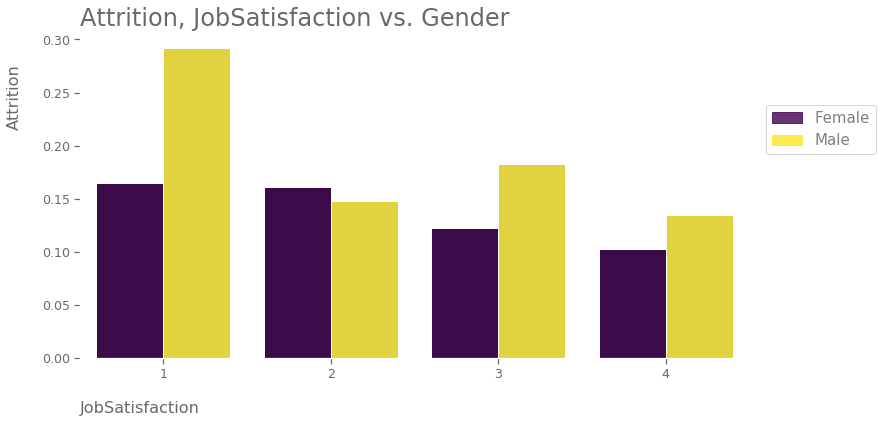

In [18]:
# facet MaritalStatus vs. Gender
p = PrettierPlot(chart_scale=12)
ax = p.make_canvas(title="Attrition, JobSatisfaction vs. Gender", y_shift=0.7)
p.facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="JobSatisfaction",
    y=train.target.name,
    split="Gender",
    y_units="fff",
    bbox = (1.2, 0.8),
    ax=ax,
)

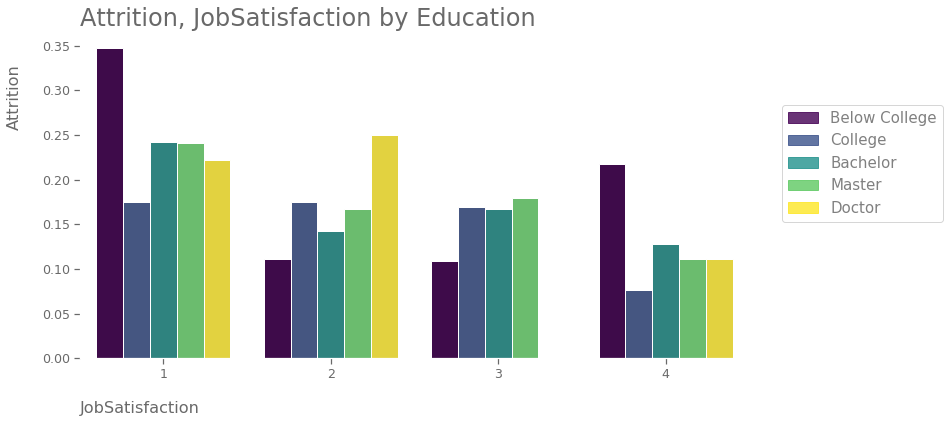

In [19]:
# facet MaritalStatus vs. Gender
p = PrettierPlot(chart_scale=12)
ax = p.make_canvas(title="Attrition, JobSatisfaction by Education", y_shift=0.7)
p.facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="JobSatisfaction",
    y=train.target.name,
    split="Education",
    y_units="fff",
    bbox = (1.3, 0.8),
    ax=ax,
    legend_labels = ['Below College','College','Bachelor','Master','Doctor']
)

<Figure size 1080x540 with 0 Axes>

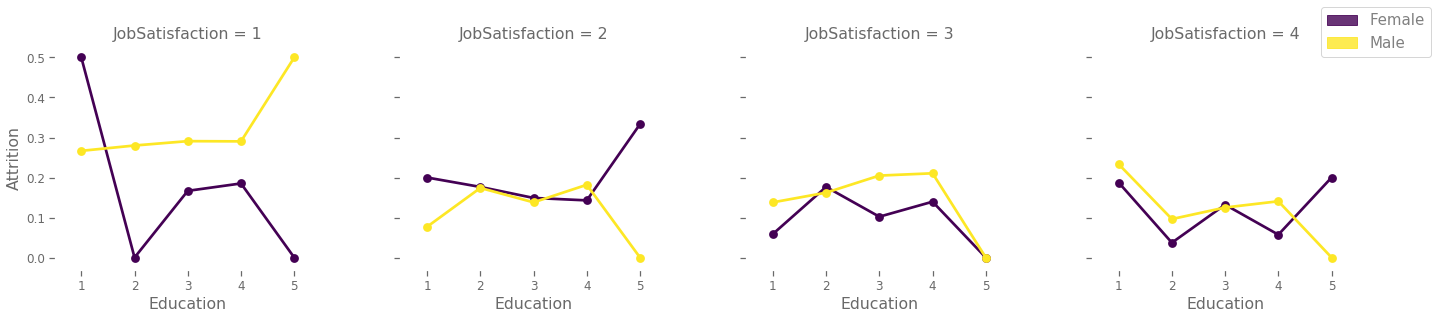

In [20]:
#
p = PrettierPlot()
p.facet_two_cat_point(
    df=train.recombine_data(train.data, train.target),
    x="Education",
    y=train.target.name,
    split="Gender",
    cat_col="JobSatisfaction",
    height=5,
    bbox=(1.3, 1.2),
#     legend_labels=["1st class", "2nd class", "3rd class"],
)

<Figure size 1080x540 with 0 Axes>

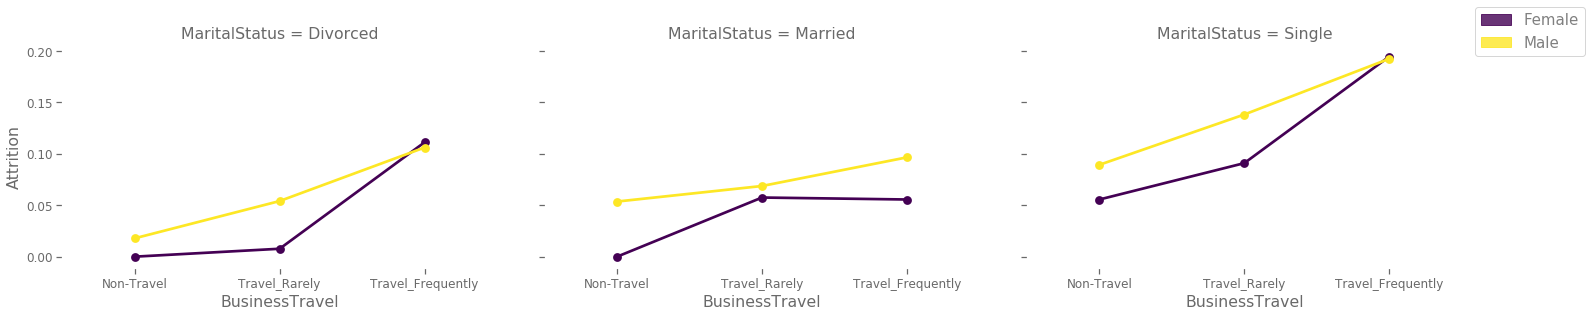

In [21]:
#
p = PrettierPlot()
p.facet_two_cat_point(
    df=train.recombine_data(train.data, train.target),
    x="BusinessTravel",
    y=train.target.name,
    split="Gender",
    cat_col="MaritalStatus",
    aspect = 1.4,
    height=5,
    bbox=(1.3, 1.2),
)

<Figure size 1080x540 with 0 Axes>

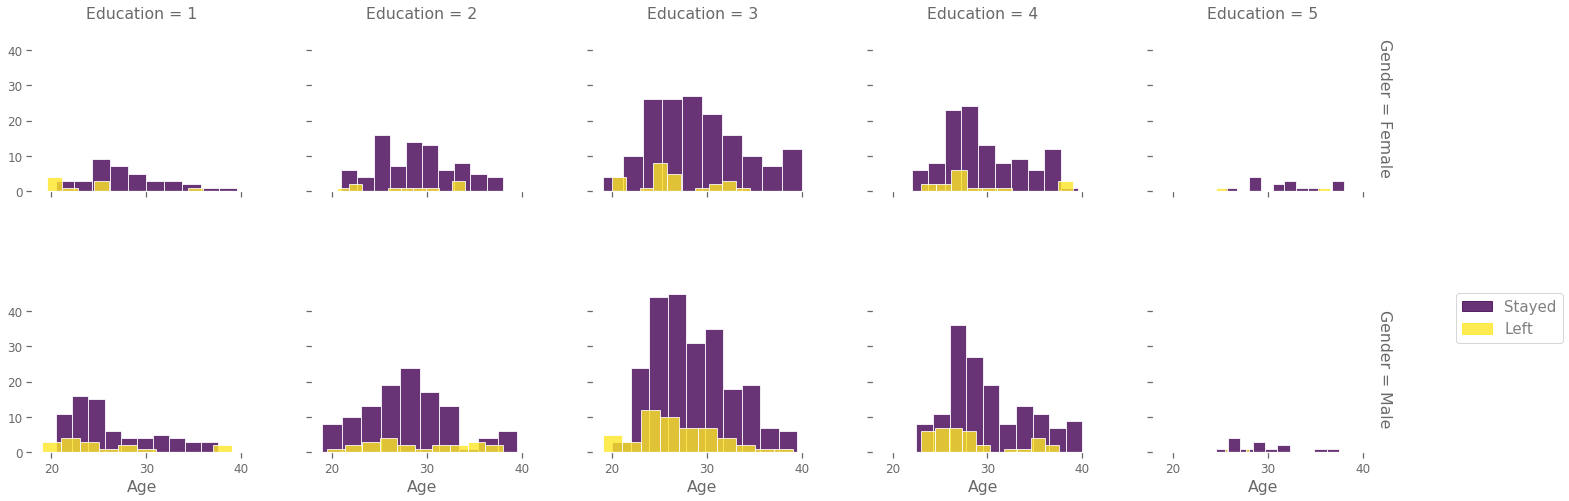

In [22]:
#
p = PrettierPlot()
p.facet_cat_num_hist(
    df=train.recombine_data(train.data, train.target),
    split=train.target.name,
    legend_labels=["Stayed", "Left"],
    cat_row="Gender",
    cat_col="Education",
    num_col="Age",
    bbox=(1.9, 1.0),
    height=4,
    aspect=1,
)

<Figure size 1080x540 with 0 Axes>

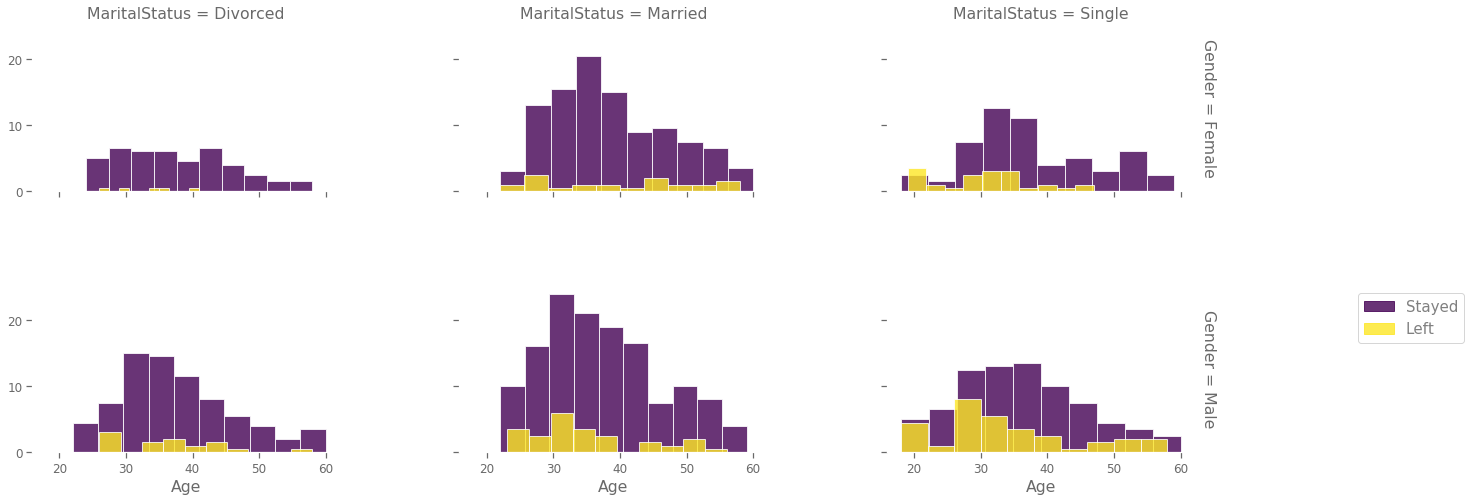

In [23]:
#
p = PrettierPlot()
p.facet_cat_num_hist(
    df=train.recombine_data(train.data, train.target),
    split=train.target.name,
    legend_labels=["Stayed", "Left"],
    cat_row="Gender",
    cat_col="MaritalStatus",
    num_col="Age",
    bbox=(1.9, 1.0),
    height=4,
    aspect=1.5,
)

## Target variable evaluation

<a id = 'Target-variable-evaluation'></a>

In [24]:
# null score
pd.Series(train.target).value_counts(normalize=True)

0    0.838435
1    0.161565
Name: Attrition, dtype: float64

# Data preparation

<a id = 'Data-preparation'></a>

## Missing data

<a id = 'Missing-data'></a>

In [25]:
# evaluate missing data
train.eda_missing_summary()

no nulls


In [26]:
# evaluate missing data
valid.eda_missing_summary()

no nulls


In [27]:
# compare feature with missing data
train.missing_col_compare(train=train.data, validation=valid.data)

missing in validation, not train
set()

missing in train, not validation
set()


<a id = 'Impute'></a>

## Feature engineering

<a id = 'Feature-engineering'></a>

### Handcrafted

<a id = 'Handcrafted'></a>

### Polynomial features

<a id = 'Polynomial-features'></a>

In [28]:
# transform pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasTransformer(PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"]),
    )),
])

train.data = polynomial_pipe.fit_transform(train.data)
valid.data = polynomial_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

### Encoding

<a id = 'Encoding'></a>

In [29]:
# counts of unique values in training data string columns
train.data[train.data.mlm_dtypes["category"]].apply(pd.Series.nunique, axis=0)

BusinessTravel              3
Department                  3
Education                   5
EducationField              6
EnvironmentSatisfaction     4
Gender                      2
JobInvolvement              4
JobLevel                    5
JobRole                     9
JobSatisfaction             4
MaritalStatus               3
OverTime                    2
PerformanceRating           2
RelationshipSatisfaction    4
StockOptionLevel            4
WorkLifeBalance             4
dtype: int64

In [30]:
# print unique values in each object columns
for col in train.data[train.data.mlm_dtypes["category"]]:
    print(col, np.unique(train.data[col]))

BusinessTravel ['Non-Travel' 'Travel_Frequently' 'Travel_Rarely']
Department ['Human Resources' 'Research & Development' 'Sales']
Education [1 2 3 4 5]
EducationField ['Human Resources' 'Life Sciences' 'Marketing' 'Medical' 'Other'
 'Technical Degree']
EnvironmentSatisfaction [1 2 3 4]
Gender ['Female' 'Male']
JobInvolvement [1 2 3 4]
JobLevel [1 2 3 4 5]
JobRole ['Healthcare Representative' 'Human Resources' 'Laboratory Technician'
 'Manager' 'Manufacturing Director' 'Research Director'
 'Research Scientist' 'Sales Executive' 'Sales Representative']
JobSatisfaction [1 2 3 4]
MaritalStatus ['Divorced' 'Married' 'Single']
OverTime ['No' 'Yes']
PerformanceRating [3 4]
RelationshipSatisfaction [1 2 3 4]
StockOptionLevel [0 1 2 3]
WorkLifeBalance [1 2 3 4]


In [31]:
# counts of unique values in validation data string columns
valid.data[valid.data.mlm_dtypes["category"]].apply(pd.Series.nunique, axis=0)

BusinessTravel              3
Department                  3
Education                   5
EducationField              6
EnvironmentSatisfaction     4
Gender                      2
JobInvolvement              4
JobLevel                    5
JobRole                     9
JobSatisfaction             4
MaritalStatus               3
OverTime                    2
PerformanceRating           2
RelationshipSatisfaction    4
StockOptionLevel            4
WorkLifeBalance             4
dtype: int64

In [32]:
# print unique values in each object columns
for col in valid.data[valid.data.mlm_dtypes["category"]]:
    print(col, np.unique(valid.data[col]))

BusinessTravel ['Non-Travel' 'Travel_Frequently' 'Travel_Rarely']
Department ['Human Resources' 'Research & Development' 'Sales']
Education [1 2 3 4 5]
EducationField ['Human Resources' 'Life Sciences' 'Marketing' 'Medical' 'Other'
 'Technical Degree']
EnvironmentSatisfaction [1 2 3 4]
Gender ['Female' 'Male']
JobInvolvement [1 2 3 4]
JobLevel [1 2 3 4 5]
JobRole ['Healthcare Representative' 'Human Resources' 'Laboratory Technician'
 'Manager' 'Manufacturing Director' 'Research Director'
 'Research Scientist' 'Sales Executive' 'Sales Representative']
JobSatisfaction [1 2 3 4]
MaritalStatus ['Divorced' 'Married' 'Single']
OverTime ['No' 'Yes']
PerformanceRating [3 4]
RelationshipSatisfaction [1 2 3 4]
StockOptionLevel [0 1 2 3]
WorkLifeBalance [1 2 3 4]


In [33]:
# identify values that are present in the training data but not the validation data, and vice versa
for col in train.data.mlm_dtypes["category"]:
    train_values = train.data[col].unique()
    valid_values = valid.data[col].unique()

    train_diff = set(train_values) - set(valid_values)
    valid_diff = set(valid_values) - set(train_values)

    if len(train_diff) > 0 or len(valid_diff) > 0:
        print("\n\n*** " + col)
        print("Value present in training data, not in validation data")
        print(train_diff)
        print("Value present in validation data, not in training data")
        print(valid_diff)
    else:
        print(' {} = fully represented'.format(col))

 BusinessTravel = fully represented
 Department = fully represented
 Education = fully represented
 EducationField = fully represented
 EnvironmentSatisfaction = fully represented
 Gender = fully represented
 JobInvolvement = fully represented
 JobLevel = fully represented
 JobRole = fully represented
 JobSatisfaction = fully represented
 MaritalStatus = fully represented
 OverTime = fully represented
 PerformanceRating = fully represented
 RelationshipSatisfaction = fully represented
 StockOptionLevel = fully represented
 WorkLifeBalance = fully represented


In [ ]:
# encode pipeline
encode_pipe = PandasFeatureUnion([
    ("nominal", make_pipeline(
        DataFrameSelector(include_columns=nominal),
        PandasTransformer(OneHotEncoder(drop="first")),
    )),
    ("ordinal", make_pipeline(
        DataFrameSelector(include_columns=list(ordinal_encodings.keys())),
        PandasTransformer(OrdinalEncoder(categories=list(ordinal_encodings.values()))),
    )),
    ("bin", make_pipeline(
        DataFrameSelector(include_columns=train.data.mlm_dtypes["continuous"]),
        PandasTransformer(KBinsDiscretizer(encode="ordinal")),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=nominal + list(ordinal_encodings.keys())),
    )),
])

train.data = encode_pipe.fit_transform(train.data)
valid.data = encode_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

In [ ]:
#
target_encode_pipe = PandasFeatureUnion([
    ("target", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=TargetEncoder,
        ),
    )),
    ("woe", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=WOEEncoder,
        ),
    )),
    ("catboost", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=CatBoostEncoder,
        ),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["category"]),
    )),
])

train.data = target_encode_pipe.fit_transform(train.data)
valid.data = target_encode_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

## Feature transformation

<a id = 'Feature-transformation'></a>

### Skew correction

<a id = 'Skew-correction'></a>

In [ ]:
# skew correction pipeline
skew_pipe = PandasFeatureUnion([
    ("skew", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        DualTransformer(),
    )),    
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"]),
    )),
])

# train.data = skew_pipe.fit_transform(train.data)
# valid.data = skew_pipe.transform(valid.data)

# train.update_dtypes()
# valid.update_dtypes()

In [ ]:
# evaluate skew of number features - training data
train.skew_summary()

In [ ]:
# evaluate skew of number features - validation data
valid.skew_summary()

### Scaling

<a id = 'Scaling'></a>

In [ ]:
# scale pipeline
scale_pipe = PandasFeatureUnion([
    ("scale", make_pipeline(
        DataFrameSelector(),
        PandasTransformer(RobustScaler())
    )),
])

train.data = scale_pipe.fit_transform(train.data)
valid.data = scale_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

## Outliers


<a id = 'Outliers'></a>

In [ ]:
# identify outliers using IQR
train_pipe = Pipeline([
    ("outlier",train.OutlierIQR(
                outlier_count=5,
                iqr_step=1.5,
                features=train.data.mlm_dtypes["continuous"],
                drop_outliers=False,))
    ])
train.data = train_pipe.transform(train.data)

# capture outliers
iqr_outliers = np.array(sorted(train_pipe.named_steps["outlier"].outliers))
print(iqr_outliers)

In [ ]:
# identify outliers using Isolation Forest
clf = IsolationForest(
    behaviour="new", max_samples=train.data.shape[0], random_state=0, contamination=0.01
)
clf.fit(train.data[train.data.columns])
preds = clf.predict(train.data[train.data.columns])

# evaluate index values
mask = np.isin(preds, -1)
if_outliers = np.array(train.data[mask].index)
print(if_outliers)

In [ ]:
# identify outliers using extended isolation forest
train_pipe = Pipeline([
    ("outlier",train.ExtendedIsoForest(
                columns=train.data.mlm_dtypes["continuous"],
                n_trees=100,
                sample_size=256,
                extension_level=1,
                anomalies_ratio=0.03,
                drop_outliers=False,))
    ])
train.data = train_pipe.transform(train.data)

# capture outliers
eif_outliers = np.array(sorted(train_pipe.named_steps["outlier"].outliers))
print(eif_outliers)

In [ ]:
# identify outliers that are identified in multiple algorithms
outliers = reduce(np.intersect1d, (iqr_outliers, if_outliers, eif_outliers))
# outliers = reduce(np.intersect1d, (if_outliers, eif_outliers))
print(outliers)

In [ ]:
# review outlier identification summary
outlier_summary = train.outlier_summary(iqr_outliers=iqr_outliers,
                             if_outliers=if_outliers,
                             eif_outliers=eif_outliers
                            )
outlier_summary[outlier_summary["count"] >= 3].index

In [ ]:
# remove outlers from predictors and response
outliers = np.array([123, 63, 976, 237, 126, 914, 473, 187, 270, 875, 1116, 427])
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)

## Additional exploratory data analysis

<a id = 'Additional-exploratory-data-analysis'></a>

In [ ]:
# correlation heat map with most highly correlated features relative to the target
p = PrettierPlot(plot_orientation='tall',chart_scale=15)
ax = p.make_canvas()
p.corr_heatmap_target(
    df=train.data,
    target=train.target,
    thresh=0.2,
    annot=True,
    ax=ax,
)

# Feature importance

<a id = 'Feature-importance'></a>

In [ ]:
# generate feature importance summary
estimators = [
    LGBMClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    XGBClassifier,
]

fs = train.FeatureSelector(
    data=train.data,
    target=train.target,
    estimators=estimators,
)
feature_selector_summary = fs.feature_selector_suite(
    save_to_csv=True,
    n_jobs=5,
)

In [ ]:
# calculate cross-validation performance
estimators = [
    SVC,
    LGBMClassifier,
    LogisticRegression,
    XGBClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    #AdaBoostClassifier,
    ExtraTreesClassifier,
    KNeighborsClassifier,
]

cv_summary = fs.feature_selector_cross_val(
    feature_selector_summary=feature_selector_summary,
#     feature_selector_summary=pd.read_csv("feature_selection_summary_2001291515.csv", index_col=0),
    estimators=estimators,
    scoring=["accuracy","roc_auc"],
    n_folds=5,
    step=1,
    n_jobs=4,
    verbose=True,
)

###### Accuracy

In [ ]:
# visualize CV performance for diminishing feature set
fs.feature_selector_results_plot(
#     cv_summary=cv_summary,
#     feature_selector_summary=feature_selector_summary,
    cv_summary= pd.read_csv(".csv", index_col=0),
    feature_selector_summary=pd.read_csv("feature_selection_summary_2001291515.csv", index_col=0),
    scoring="accuracy",
    title_scale=0.8,
)

In [ ]:
cross_val_features_df = fs.create_cross_val_features_df(
    scoring="accuracy",
    cv_summary=cv_summary,
    feature_selector_summary=feature_selector_summary,
#     cv_summary= pd.read_csv("cv_summary_2001291517.csv", index_col=0),
#     feature_selector_summary=pd.read_csv("feature_selection_summary_2001291333.csv", index_col=0),
)

In [ ]:
cross_val_feature_dict = fs.create_cross_val_features_dict(
    cross_val_features_df=cross_val_features_df
)

###### ROC AUC

In [ ]:
# visualize CV performance for diminishing feature set
fs.feature_selector_results_plot(
    metric="roc_auc",
    title_scale=0.8,
)

In [ ]:
cross_val_features_df = fs.create_cross_val_features_df(
    scoring="roc_auc",
    cv_summary=cv_summary,
    feature_selector_summary=feature_selector_summary,
#     cv_summary= pd.read_csv("cv_summary_2001291517.csv", index_col=0),
#     feature_selector_summary=pd.read_csv("feature_selection_summary_2001291333.csv", index_col=0),
)

In [ ]:
cross_val_feature_dict = fs.create_cross_val_features_dict(
    cross_val_features_df=cross_val_features_df
)

# Modeling

<a id = 'Modeling'></a>

## Data preparation

<a id = 'Data-preparation-1'></a>

In [ ]:
#################################################################################
# import data
dataset = data.attrition()

# split dataset into train and validation datasets
df_train, df_valid = mlm.train_test_df_compile(data=dataset, target_col='Attrition')

continuous = [
    "Age",
    "DailyRate",
    "DistanceFromHome",
    "HourlyRate",
    "MonthlyIncome",
    "MonthlyRate",
    "PercentSalaryHike",
    "TotalWorkingYears",
    "YearsAtCompany",
    "YearsInCurrentRole",
    "YearsSinceLastPromotion",
    "YearsWithCurrManager",
]

count = [
    "NumCompaniesWorked",
    "TrainingTimesLastYear",
]

nominal = [
    "MaritalStatus",
    "EducationField",
    "Department",
    "Gender",
    "JobRole",
    "OverTime",
]

remove_features = [
    "EmployeeNumber",
    "EmployeeCount",
    "StandardHours",
    "Over18",
]

ordinal = [
    "Education",
    "EnvironmentSatisfaction",
    "JobInvolvement",
    "JobLevel",
    "JobSatisfaction",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StockOptionLevel",
    "WorkLifeBalance",
    "BusinessTravel",
]

ordinal_encodings = {
    "Education": [1, 2, 3, 4, 5],
    "EnvironmentSatisfaction": [1, 2, 3, 4],
    "JobInvolvement": [1, 2, 3, 4],
    "JobLevel": [1, 2, 3, 4, 5],
    "JobSatisfaction": [1, 2, 3, 4],
    "PerformanceRating": [3, 4],
    "RelationshipSatisfaction": [1, 2, 3, 4],
    "StockOptionLevel": [0, 1, 2, 3],
    "WorkLifeBalance": [1, 2, 3, 4],
    "BusinessTravel": ['Non-Travel','Travel_Rarely','Travel_Frequently'],
}

# import training data
# Load training data into mlmachine
train = mlm.Machine(
    data=df_train,
    target="Attrition",
    remove_features=remove_features,
    identify_as_continuous=continuous,
    identify_as_count=count,    
    identify_as_nominal=nominal,
    identify_as_ordinal=ordinal,
    ordinal_encodings=ordinal_encodings,
    target_type="category",
)

# import valid data
# Load training data into mlmachine
valid = mlm.Machine(
    data=df_valid,
    target="Attrition",
    remove_features=remove_features,
    identify_as_continuous=continuous,
    identify_as_count=count,    
    identify_as_nominal=nominal,
    identify_as_ordinal=ordinal,
    ordinal_encodings=ordinal_encodings,
)

#################################################################################
### feature transformation pipeline

# polynomial feature pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasTransformer(PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"]),
    )),
])

train.data = polynomial_pipe.fit_transform(train.data)
valid.data = polynomial_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

# encode feature pipeline
encode_pipe = PandasFeatureUnion([
    ("nominal", make_pipeline(
        DataFrameSelector(include_columns=nominal),
        PandasTransformer(OneHotEncoder(drop="first")),
    )),
    ("ordinal", make_pipeline(
        DataFrameSelector(include_columns=list(ordinal_encodings.keys())),
        PandasTransformer(OrdinalEncoder(categories=list(ordinal_encodings.values()))),
    )),
    ("bin", make_pipeline(
        DataFrameSelector(include_columns=train.data.mlm_dtypes["continuous"]),
        PandasTransformer(KBinsDiscretizer(encode="ordinal")),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=nominal + list(ordinal_encodings.keys())),
    )),
])

train.data = encode_pipe.fit_transform(train.data)
valid.data = encode_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

# target encoded feature pipeline
#
target_encode_pipe = PandasFeatureUnion([
    ("target", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=TargetEncoder,
        ),
    )),
    ("woe", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=WOEEncoder,
        ),
    )),
    ("catboost", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=CatBoostEncoder,
        ),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["category"]),
    )),
])

train.data = target_encode_pipe.fit_transform(train.data)
valid.data = target_encode_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

# skew correction pipeline
skew_pipe = PandasFeatureUnion([
    ("skew", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        DualTransformer(),
    )),    
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"]),
    )),
])

# train.data = skew_pipe.fit_transform(train.data)
# valid.data = skew_pipe.transform(valid.data)

# train.update_dtypes()
# valid.update_dtypes()

# scale pipeline
scale_pipe = PandasFeatureUnion([
    ("scale", make_pipeline(
        DataFrameSelector(),
        PandasTransformer(RobustScaler())
    )),
])

train.data = scale_pipe.fit_transform(train.data)
valid.data = scale_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

#################################################################################
# remove outliers
outliers = np.array([123, 63, 976, 237, 126, 914, 473, 187, 270, 875, 1116, 427])
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)

# accuracy >= 7
# train.data = train.data[best_columns]
# valid.data = valid.data[best_columns]

print('completed')

## Bayesian hyper-parameter optimization

<a id = 'Bayesian-hyper-parameter-optimization'></a>

In [ ]:
# model/parameter space
all_space = {
    "LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None, "balanced"]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "boosting_type": hp.choice("boosting_type", ["gbdt", "dart", "goss"])
        # ,'boosting_type': hp.choice('boosting_type'
        #                    ,[{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'goss', 'subsample': 1.0}])
        ,
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_samples": hp.uniform("min_child_samples", 20, 500),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "num_leaves": hp.uniform("num_leaves", 8, 150),
        "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.5),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.uniform("subsample_for_bin", 20000, 400000),
    },
#     "LogisticRegression": {
#         "C": hp.loguniform("C", np.log(0.001), np.log(0.2)),
#         "penalty": hp.choice("penalty", ["l1", "l2"]),
#     },
    "XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "gamma": hp.uniform("gamma", 0.0, 10),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_weight": hp.uniform("min_child_weight", 1, 20),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "subsample": hp.uniform("subsample", 0.3, 1),
    },
    "RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "GradientBoostingClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "loss": hp.choice("loss", ["deviance", "exponential"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "AdaBoostClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "algorithm": hp.choice("algorithm", ["SAMME", "SAMME.R"]),
    },
    "ExtraTreesClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "criterion": hp.choice("criterion", ["gini", "entropy"]),
    },
    "SVC": {
        "C": hp.uniform("C", 0.001, 15),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovo", "ovr"]),
        "gamma": hp.uniform("gamma", 0.000000001, 5),
    },
    "KNeighborsClassifier": {
        "algorithm": hp.choice("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
        "n_neighbors": hp.choice("n_neighbors", np.arange(1, 20, dtype=int)),
        "weights": hp.choice("weights", ["distance", "uniform"]),
    },
}

In [ ]:
# execute bayesian optimization grid search
train.exec_bayes_optim_search(
    all_space=all_space,
    data=train.data,
    target=train.target,
    scoring="roc_auc",
    n_folds=5,
    n_jobs=8,
    iters=2000,
    verbose=0,
)

##### Model loss by iteration

In [ ]:
# read scores summary table
bayes_optim_summary = pd.read_csv("", na_values="nan")
bayes_optim_summary[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary["estimator"]):
    train.model_loss_plot(bayes_optim_summary=bayes_optim_summary, estimator=estimator)

##### Parameter selection by iteration

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary["estimator"]):
    train.modelParamPlot(
        bayes_optim_summary=bayes_optim_summary,
        estimator=estimator,
        all_space=all_space,
        n_iter=100,
        chart_scale=15,
    )

In [ ]:
sample_space = {
                'param': hp.uniform('param', np.log(0.4), np.log(0.6))
#     "": 0.000001 + hp.uniform("gamma", 0.000001, 10)
    #             'param2': hp.loguniform('param2', np.log(0.001), np.log(0.01))
}

train.sample_plot(sample_space, 1000)

## Model performance evaluation - standard models

<a id = 'Model-performance-evaluation-standard-models'></a>

In [ ]:
top_models = train.top_bayes_optim_models(bayes_optim_summary=bayes_optim_summary, num_models=1)
top_models

In [ ]:
# classification panel, single model
estimator = "XGBClassifier"; model_iter = 218
# estimator = 'GradientBoostingClassifier'; model_iter = 590
# estimator = 'XGBClassifier'; model_iter = 380

model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)

train.binary_classification_panel(
    model=model, X_train=train.data, y_train=train.target, cm_labels=['Stays', 'Quits']
)

In [ ]:
# create classification reports
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.binary_classification_panel(
            model=model, X_train=train.data, y_train=train.target, cm_labels=['Stays', 'Quits']
        )

## Validation set evaluation - standard models

<a id = 'Validation-set-evaluation-standard-models'></a>

In [ ]:
## standard model fit and predict
# select estimator and iteration
# estimator = "LGBMClassifier"; model_iter = 476
estimator = "XGBClassifier"; model_iter = 418
# estimator = "RandomForestClassifier"; model_iter = 382
# estimator = "GradientBoostingClassifier"; model_iter = 238
# estimator = "SVC"; model_iter = 135

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)

# classification panel for validation data
train.binary_classification_panel(
    model=model,
    X_train=train.data,
    y_train=train.target,
    X_valid=valid.data,
    y_valid=valid.target,
    cm_labels=['Stays', 'Quits'],
)

In [ ]:
# create classification reports
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.binary_classification_panel(
            model=model,
            X_train=train.data,
            y_train=train.target,
            X_valid=valid.data,
            y_valid=valid.target,
            labels=[0, 1],
        )

## Model explanability


<a id = 'Feature-importance'></a>

In [ ]:
# 
estimator = "ExtraTreesClassifier"; model_iter = 145
estimator = "XGBClassifier"; model_iter = 218

model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)

model.fit(train.data.values, train.target.values)

##### Permutation importance

In [ ]:
# permutation importance - how much does performance decrease when shuffling a certain feature?
perm = PermutationImportance(model.model, random_state=1).fit(train.data, train.target)
eli5.show_weights(perm, feature_names=feature_names)

##### SHAP values - training data

###### Force plots - single observations

In [ ]:
# SHAP force plots for individual observations
for i in train.data.index[:5]:
    train.single_shap_viz_tree(obsIx=i, model=model, data=train.data)

###### Force plots -multiple observations

In [ ]:
# SHAP force plot a set of data
visual = train.multi_shap_viz_tree(obs_ixs=train.data.index, model=model, data=train.data)
visual

###### Dependence plots

In [ ]:
# generate SHAP values for set of observations
obs_data, _, obs_shap_values = train.multi_shap_value_tree(
    obs_ixs=train.data.index, model=model, data=train.data
)

In [ ]:
# SHAP dependence plot grid
grid_features = [
    "BusinessTravel",
    "Age",
    "WorkLifeBalance",
    "Education",
    "DistanceFromHome",
    "MonthlyIncome",
    "Gender_Male",
]

train.shap_dependence_grid(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    grid_features=grid_features,
    all_features=train.data.columns,
    dot_size=35,
    alpha=0.5,
)

In [ ]:
# single SHAP dependence plot
p = PrettierPlot()
ax = p.make_canvas()

train.shap_dependence_plot(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    scatter_feature="Age",
    color_feature="BusinessTravel",
    feature_names=train.data.columns,
    dot_size=50,
    alpha=0.5,
    ax=ax
)

In [ ]:
# SHAP dependence plots for all feature relative to an interaction feature
feature_names = train.data.columns.tolist()
top_shap = np.argsort(-np.sum(np.abs(obs_shap_values), 0))

for top_ix in top_shap:
    p = PrettierPlot()
    ax = p.make_canvas()

    train.shap_dependence_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        scatter_feature=feature_names[top_ix],
        color_feature="Age",
        feature_names=feature_names,
        dot_size=50,
        alpha=0.5,
        ax=ax
    )

###### Summary plots

In [ ]:
# SHAP summary plot
train.shap_summary_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        feature_names=train.data.columns,
    )

##### SHAP values - validation data

###### Force plots - single observations

In [ ]:
# SHAP force plots for individual observations
for i in valid.data.index[:5]:
    valid.single_shap_viz_tree(obsIx=i, model=model, data=valid.data)

###### Force plots -multiple observations

In [ ]:
# SHAP force plot a set of data
visual = valid.multi_shap_viz_tree(obs_ixs=valid.data.index, model=model, data=valid.data)
visual

###### Dependence plots

In [ ]:
# generate SHAP values for set of observations
obs_data, _, obs_shap_values = valid.multi_shap_value_tree(
    obs_ixs=valid.data.index, model=model, data=valid.data
)

In [ ]:
# SHAP dependence plot grid
grid_features = [
    "BusinessTravel",
    "Age",
    "WorkLifeBalance",
    "Education",
    "DistanceFromHome",
    "MonthlyIncome",
    "Gender_Male",
]

valid.shap_dependence_grid(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    grid_features=grid_features,
    all_features=valid.data.columns,
    dot_size=35,
    alpha=0.5,
)

In [ ]:
# single SHAP dependence plot
p = PrettierPlot()
ax = p.make_canvas()

valid.shap_dependence_plot(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    scatter_feature="Age",
    color_feature="BusinessTravel",
    feature_names=valid.data.columns,
    dot_size=50,
    alpha=0.5,
    ax=ax
)

In [ ]:
# SHAP dependence plots for all feature relative to an interaction feature
feature_names = valid.data.columns.tolist()
top_shap = np.argsort(-np.sum(np.abs(obs_shap_values), 0))

for top_ix in top_shap:
    p = PrettierPlot()
    ax = p.make_canvas()

    valid.shap_dependence_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        scatter_feature=feature_names[top_ix],
        color_feature="Age",
        feature_names=feature_names,
        dot_size=50,
        alpha=0.5,
        ax=ax
    )

###### Summary plots

In [ ]:
# SHAP summary plot
valid.shap_summary_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        feature_names=valid.data.columns,
    )

# Stacking

<a id = 'Stacking'></a>

## Primary models

<a id = 'Primary-models'></a>

In [ ]:
# get out-of-fold predictions
oof_train, oof_valid, columns = train.model_stacker(
    models=top_models,
    bayes_optim_summary=bayes_optim_summary,
    X_train=train.data.values,
    y_train=train.target.values,
    X_valid=valid.data.values,
    n_folds=10,
    n_jobs=10,
)

In [ ]:
# view correlations of predictions
p = PrettierPlot()
ax = p.make_canvas()
p.corr_heatmap(
    df=pd.DataFrame(oof_train, columns=columns), annot=True, ax=ax, vmin=0
)

## Meta model

<a id = 'Meta-model'></a>

In [ ]:
# parameter space
all_space = {
    "LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "boosting_type": hp.choice("boosting_type", ["dart"]),
        "subsample": hp.uniform("subsample", 0.5, 1),
        "learning_rate": hp.uniform("learning_rate", 0.15, 0.25),
        "max_depth": hp.choice("max_depth", np.arange(4, 20, dtype=int)),
        "min_child_samples": hp.quniform("min_child_samples", 50, 150, 5),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "num_leaves": hp.quniform("num_leaves", 30, 70, 1),
        "reg_alpha": hp.uniform("reg_alpha", 0.75, 1.25),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.quniform("subsample_for_bin", 100000, 350000, 20000),
    },
    "XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "gamma": hp.quniform("gamma", 0.0, 10, 0.05),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.01),
        "max_depth": hp.choice("max_depth", np.arange(2, 15, dtype=int)),
        "min_child_weight": hp.quniform("min_child_weight", 2.5, 7.5, 1),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "subsample": hp.uniform("subsample", 0.4, 0.7),
    },
    "RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 10, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 8000, 10, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(15, 25, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 20, dtype=int)),
    },
    "GradientBoostingClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 11, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.09, 0.01),
        "loss": hp.choice("loss", ["deviance", "exponential"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "SVC": {
        "C": hp.uniform("C", 0.00000001, 15),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovr", "ovo"]),
        "gamma": hp.uniform("gamma", 0.00000001, 1.5),
    },
}

In [ ]:
# execute bayesian optimization grid search
train.exec_bayes_optim_search(
    all_space=all_space,
    results_dir="{}_hyperopt_meta_{}.csv".format(rundate, analysis),
    X=oof_train,
    y=train.target,
    scoring="f1_micro",
    n_folds=8,
    n_jobs=10,
    iters=1000,
    verbose=0,
)

In [ ]:
# read scores summary table
analysis = "attrition"
rundate = "20190807"
bayes_optim_summary_meta = pd.read_csv("{}_hyperopt_meta_{}.csv".format(rundate, analysis))
bayes_optim_summary_meta[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary_meta["estimator"]):
    train.model_loss_plot(bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator)

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary_meta['estimator']):
    train.modelParamPlot(bayes_optim_summary = bayes_optim_summary_meta,
                         estimator=estimator,
                         all_space=all_space,
                         n_iter=100,
                         chart_scale=15)

## Model performance evaluation - stacked models

<a id = 'Model-performance-evaluation-stacked-models'></a>

In [ ]:
top_models = train.top_bayes_optim_models(
    bayes_optim_summary=bayes_optim_summary_meta, num_models=1
)
top_models

In [ ]:
# best second level learning model
estimator = "LGBMClassifier"; model_iter = 668
# estimator = "XGBClassifier"; model_iter = 380
# estimator = "RandomForestClassifier"; model_iter = 411
# estimator = "GradientBoostingClassifier"; model_iter = 590
# estimator = "SVC"; model_iter = 135

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)
train.binary_classification_panel(
    model=model, X_train=oof_train, y_train=train.target, labels=[0, 1]
)

In [ ]:
# create classification reports
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary_meta,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.binary_classification_panel(
            model=model, X_train=oof_train, y_train=train.target, labels=[0, 1], n_folds=4
        )

## Validation set evaluation - stacked models


<a id = 'Validation-set-evaluation-stacked-models'></a>

In [ ]:
## standard model fit and predict
# select estimator and iteration
estimator = "LGBMClassifier"; model_iter = 668
# estimator = "XGBClassifier"; model_iter = 380
# estimator = "RandomForestClassifier"; model_iter = 411
# estimator = "GradientBoostingClassifier"; model_iter = 590
# estimator = "SVC"; model_iter = 135

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)
model.fit(oof_train, train.target.values)

# fit model and make predictions
y_pred = model.predict(oof_valid)

In [ ]:
train.binary_classification_panel(
    model=model,
    X_train=oof_train,
    y_train=train.target,
    X_valid=oof_valid,
    y_valid=valid.target,
    labels=[0, 1],
)

In [ ]:
# create classification reports
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary_meta,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.binary_classification_panel(
            model=model,
            X_train=oof_train,
            y_train=train.target,
            X_valid=oof_valid,
            y_valid=valid.target,
            labels=[0, 1],
        )